# 🔬 SKINDX: Advanced Skin Cancer Classification
Deep Learning Pipeline with PyTorch & MLflow Tracking
---

🎯 **Project Overview**

This notebook demonstrates state-of-the-art skin cancer detection using the HAM10000 dataset - a comprehensive collection of 10,015 dermatoscopic images spanning 7 different skin lesion types. We tackle the challenging problem of **highly imbalanced medical data** through advanced data augmentation and class balancing techniques.

**Key Achievement**: xx% accuracy on HAM10000 → xx% on external ISIC 2019 validation

---

🏗️ **Technical Architecture**

* **🐳 Environment**: NVIDIA PyTorch Docker container (`nvcr.io/nvidia/pytorch:25.06-py3`)
* **⚙️ Hardware**: GPU acceleration required
* **🛠️ Stack**: Docker + WSL2 + UV package manager
* **📊 Tracking**: MLflow for comprehensive experiment management
* **🎯 Model**: CNN baseline → ResNet-50 transfer learning progression

---

🎪 **Core Challenges & Solutions**

**1. Extreme Class Imbalance**
- **Problem**: Nevus (nv) dominates with 6,705 samples vs rare classes with <400 samples
- **Solution**: Intelligent class-specific augmentation rates (1x to 50x multipliers)

**2. Medical Image Complexity**
- **Problem**: Subtle visual differences between lesion types
- **Solution**: Advanced data augmentation (rotation, flips, color jitter) + transfer learning

**3. Real-world Generalization**
- **Problem**: Models often fail on external datasets
- **Solution**: External validation on ISIC 2019 (24,703 completely unseen images)

---

- 🚀 **Key Features**

* **🎯 MLflow Integration**: Complete experiment tracking, model versioning, and artifact management
* **📊 Professional Evaluation**: Custom Tester class with confusion matrices, confidence analysis
* **🔄 Smart Data Balancing**: Class-specific augmentation preventing both under/over-representation
* **⏰ Early Stopping**: Automated training termination to prevent overfitting
* **📈 Comprehensive Visualization**: Training curves, misclassification analysis, performance breakdown
* **🧪 External Validation**: Real-world performance testing on independent datasets

---

📋 **7 Skin Lesion Classes**

1. **akiec** - Actinic keratoses and intraepithelial carcinoma
2. **bcc** - Basal cell carcinoma  
3. **bkl** - Benign keratosis-like lesions
4. **df** - Dermatofibroma
5. **mel** - Melanoma
6. **nv** - Melanocytic nevi
7. **vasc** - Vascular lesions

---

⚡ **Quick Start**

```bash
# Build and run the complete environment
make dev
```

**Level**: Intermediate Data Science

**Duration**: ~2-3 hours for full pipeline execution

**Output**: Production-ready skin cancer classification model with external validation

Check out a shorter version of this notebook on [Kaggle](https://www.kaggle.com/code/lizk75/skin-cancer-resnet-balanced-98-acc)

## 📚 Import Libraries 

In [1]:
# ============================================================================
# STANDARD LIBRARY IMPORTS
# ============================================================================
import os
import sys
import time
import tempfile
import subprocess
import random
from glob import glob

# ============================================================================
# THIRD-PARTY DATA & COMPUTATION LIBRARIES
# ============================================================================
import numpy as np
import pandas as pd

# ============================================================================
# VISUALIZATION LIBRARIES
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# MACHINE LEARNING & DATA SCIENCE LIBRARIES
# ============================================================================
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# ============================================================================
# DEEP LEARNING - PyTorch Core
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ============================================================================
# DEEP LEARNING - Computer Vision
# ============================================================================
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# ============================================================================
# PROGRESS TRACKING & UTILITIES
# ============================================================================
from tqdm import tqdm

# ============================================================================
# EXPERIMENT TRACKING & API
# ============================================================================
import mlflow
import requests

In [2]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0)}")

CUDA available: True
Device: NVIDIA GeForce RTX 5080


In [3]:
input_path = "datasets/skin_cancer/HAM10000/"

## ⚙️ Setup MLflow locally

In [4]:
def is_mlflow_running():
    try:
        requests.get("http://localhost:5000", timeout=2)
        return True
    except:
        return False

if not is_mlflow_running():
    print("Starting MLflow server...")
    subprocess.Popen(["mlflow", "server", "--host", "0.0.0.0", "--port", "5000", "--backend-store-uri", "file:///workspace/mlruns"])
    time.sleep(3)
else:
    print("MLflow server already running!")

mlflow.set_tracking_uri("http://localhost:5000")
USER_NAME = "lisekarimi"
EXPERIMENT_NAME = "skin cancer classification"
try:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    print(f"Created new experiment with ID: {experiment_id}")
except:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment with ID: {experiment_id}")
mlflow.set_experiment(EXPERIMENT_NAME)
print("MLflow setup complete!")

Starting MLflow server...


[2025-08-22 17:54:48 +0000] [1257] [INFO] Starting gunicorn 23.0.0
[2025-08-22 17:54:48 +0000] [1257] [INFO] Listening at: http://0.0.0.0:5000 (1257)
[2025-08-22 17:54:48 +0000] [1257] [INFO] Using worker: sync
[2025-08-22 17:54:48 +0000] [1258] [INFO] Booting worker with pid: 1258
[2025-08-22 17:54:48 +0000] [1259] [INFO] Booting worker with pid: 1259
[2025-08-22 17:54:48 +0000] [1260] [INFO] Booting worker with pid: 1260
[2025-08-22 17:54:48 +0000] [1261] [INFO] Booting worker with pid: 1261


Using existing experiment with ID: 959049885417408975
MLflow setup complete!


## 📥 Load Metadata

- Download manually from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
- Keep only: HAM10000_metadata.csv, HAM10000_images_part_1/, HAM10000_images_part_2/
- Remove: hmnist_*.csv files (preprocessed versions not needed)

In [5]:
# Load metadata
metadata = pd.read_csv(os.path.join(input_path, "HAM10000_metadata.csv"))

# Get total number of samples in dataset
num_examples = metadata.values.shape[0]
print(f"✅ Dataset loaded: {num_examples} samples")

# Display dataframe
print("\n📊 First 5 rows:")
display(metadata.head())

✅ Dataset loaded: 10015 samples

📊 First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## 📊 Class Distribution

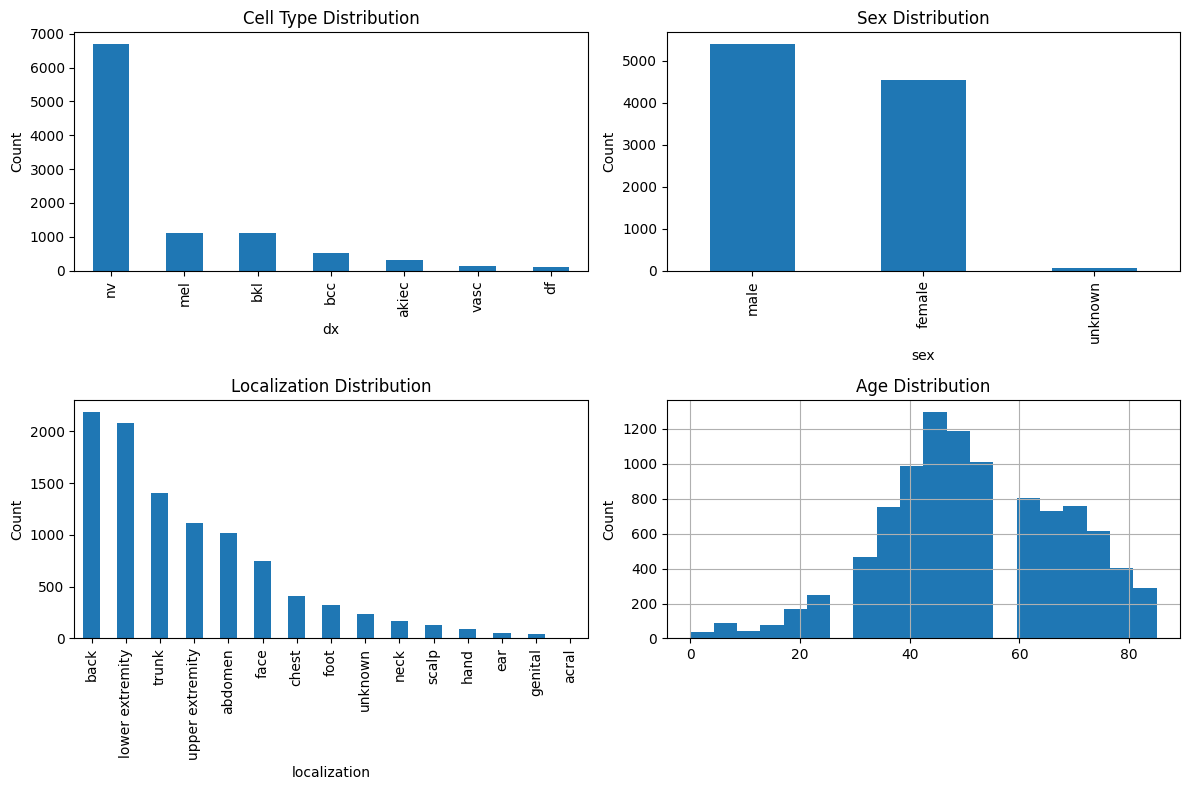

In [6]:
# Simple data distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Cell type distribution
metadata['dx'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Cell Type Distribution')
axes[0,0].set_ylabel('Count')

# Sex distribution
metadata['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')
axes[0,1].set_ylabel('Count')

# Localization distribution
metadata['localization'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Localization Distribution')
axes[1,0].set_ylabel('Count')

# Age distribution (simple histogram)
metadata['age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Our target variable is highly imbalanced. While there are multiple strategies to handle this, in this notebook we’ll begin by splitting the classes, applying resampling, and then merging them back into a single dataframe.

Step 1: Balance the dataset before any splitting

In [7]:
# Define label names first
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Add numeric labels to metadata
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
print(metadata['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [8]:
# Separate each class
df_0 = metadata[metadata['label'] == 0]  # akiec
df_1 = metadata[metadata['label'] == 1]  # bcc
df_2 = metadata[metadata['label'] == 2]  # bkl
df_3 = metadata[metadata['label'] == 3]  # df
df_4 = metadata[metadata['label'] == 4]  # mel
df_5 = metadata[metadata['label'] == 5]  # nv
df_6 = metadata[metadata['label'] == 6]  # vasc

In [9]:
# Resample each class to 500 samples
n_samples = 500  # Samples per class
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [10]:
# Combine back into single dataframe
metadata_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced,
                             df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])
print("Balanced dataset distribution:")
print(metadata_balanced['label'].value_counts().sort_index())

Balanced dataset distribution:
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


## 🖼️ Load Images
Step 2: Load images for balanced dataset only

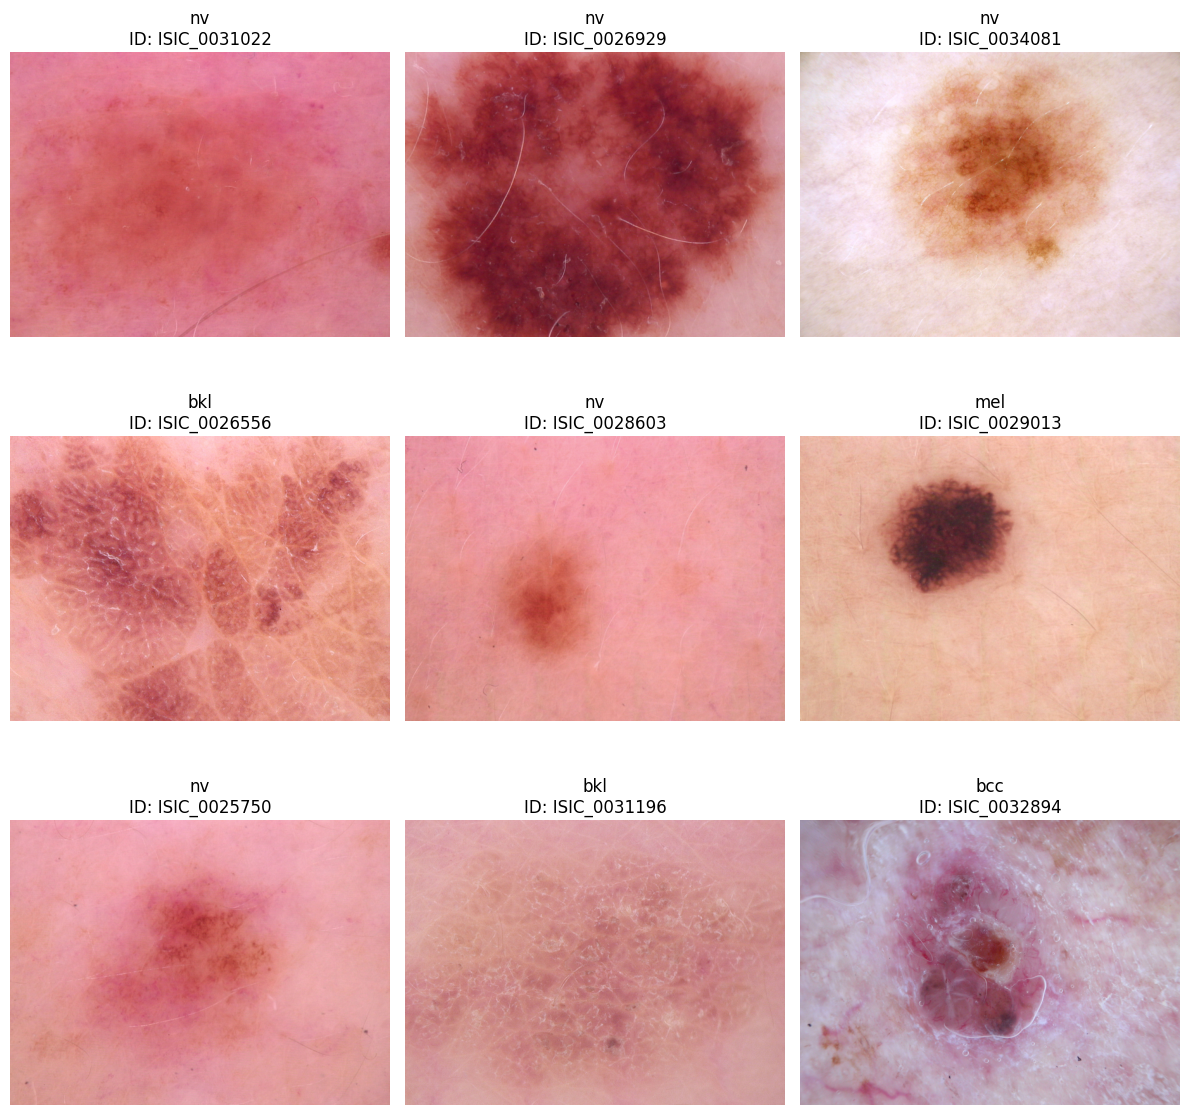

In [11]:
# Create path mapping using glob
image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(input_path, '*', '*.jpg'))}

# Get 9 random image IDs
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(12, 12))
for i, img_id in enumerate(random_ids):
   img_path = image_path[img_id]
   img = Image.open(img_path)

   # Find the label for this image ID
   row = metadata[metadata['image_id'] == img_id]
   if not row.empty:
       label = row['dx'].iloc[0]
   else:
       label = 'Unknown'

   plt.subplot(3, 3, i+1)
   plt.imshow(img)
   plt.title(f'{label}\nID: {img_id}')
   plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Add paths to balanced dataframe
metadata_balanced['path'] = metadata_balanced['image_id'].map(image_path.get)
metadata_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,datasets/skin_cancer/HAM10000/HAM10000_images_...
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,datasets/skin_cancer/HAM10000/HAM10000_images_...
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,datasets/skin_cancer/HAM10000/HAM10000_images_...
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,datasets/skin_cancer/HAM10000/HAM10000_images_...
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,datasets/skin_cancer/HAM10000/HAM10000_images_...


In [13]:
# Load images directly into dataframe
SIZE = 32  # Image size
metadata_balanced['image'] = metadata_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))
metadata_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,datasets/skin_cancer/HAM10000/HAM10000_images_...,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,datasets/skin_cancer/HAM10000/HAM10000_images_...,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,datasets/skin_cancer/HAM10000/HAM10000_images_...,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,datasets/skin_cancer/HAM10000/HAM10000_images_...,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,datasets/skin_cancer/HAM10000/HAM10000_images_...,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."


In [14]:
# Convert dataframe to numpy arrays
X = np.asarray(metadata_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1
Y = metadata_balanced['label']  # Assign label values to Y

print(f"✅ Balanced dataset loaded!")
print(f"📊 Images shape: {X.shape}")
print(f"🏷️ Labels shape: {Y.shape}")

✅ Balanced dataset loaded!
📊 Images shape: (3500, 32, 32, 3)
🏷️ Labels shape: (3500,)


## 🎛️ Create Train/Validation/Test Splits
60% for training, 20% for validation and 20% for testing

In [15]:
# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = torch.FloatTensor(X).permute(0, 3, 1, 2).to(device) # Convert the channel order from HWC to CHW format that PyTorch CNNs expect.
y_tensor = torch.LongTensor(Y.values).to(device)
print(f"Using device: {device}")
print(f"X_tensor shape: {X_tensor.shape}")

Using device: cuda
X_tensor shape: torch.Size([3500, 3, 32, 32])


In [16]:
x_temp, x_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

print(f"Training set: {len(x_train)} samples")
print(f"Validation set: {len(x_val)} samples")
print(f"Test set: {len(x_test)} samples")

Training set: 2100 samples
Validation set: 700 samples
Test set: 700 samples


## 🚀 Model Training Pipeline

In [17]:
def train_cnn_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    data_balancing,
    scheduler=None,
    num_epochs=50,
    patience=10,
    image_size=32,
    data_augmentation=False,
    notes="Document model modifications and experiments for easy tracking"):

    # Auto-generate run name with model info
    run_name = f"{model.__class__.__name__}_Size{image_size}_Aug{data_augmentation}_Batch{train_loader.batch_size}"

    with mlflow.start_run(run_name=run_name):
        mlflow.set_tag("user", USER_NAME)
        mlflow.set_tag("notes", notes)

        # Log hyperparameters
        mlflow.log_params({
            "model_type": model.__class__.__name__,
            "epochs": num_epochs,
            "batch_size": train_loader.batch_size,
            "image_size": image_size,
            "data_augmentation": data_augmentation,
            "patience": patience,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "optimizer": optimizer.__class__.__name__,
            "scheduler": scheduler.__class__.__name__ if scheduler else "None",
            "loss_function": criterion.__class__.__name__,
            "data_balancing": data_balancing,
            "transfer_learning": hasattr(model, 'fc'),
            "frozen_layers": "None",
            "train_samples": len(train_loader.dataset),
            "val_samples": len(val_loader.dataset),
            "test_samples": len(test_loader.dataset)
        })

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        # Early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
        best_epoch = 0

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for images, labels in progress_bar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                current_loss = train_loss / (progress_bar.n + 1)
                current_acc = (train_correct / train_total) * 100
                progress_bar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'accuracy': f'{current_acc:.2f}%'
                })

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            # Calculate final metrics
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            train_loss_avg = train_loss / len(train_loader)
            val_loss_avg = val_loss / len(val_loader)
            # Add scheduler step here
            if scheduler:
                scheduler.step(val_loss_avg)

            # Store metrics
            train_losses.append(train_loss_avg)
            val_losses.append(val_loss_avg)
            train_accs.append(train_acc * 100)
            val_accs.append(val_acc * 100)

            # Log metrics to MLflow
            mlflow.log_metrics({
                "train_loss": train_loss_avg,
                "val_loss": val_loss_avg,
                "train_accuracy": train_acc * 100,
                "val_accuracy": val_acc * 100,
                "learning_rate": optimizer.param_groups[0]['lr']
            }, step=epoch)

            # Print metrics
            print(f'Epoch {epoch+1}: loss: {train_loss_avg:.4f} - accuracy: {train_acc*100:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc*100:.2f}%')

            # Early stopping check
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                patience_counter = 0
                best_model_state = model.state_dict().copy()
                best_epoch = epoch + 1
                print('Validation loss improved. Best model updated.')
            else:
                patience_counter += 1
                print(f'No improvement. Patience: {patience_counter}/{patience}')

                if patience_counter >= patience:
                    print(f'Early stopping triggered after {epoch+1} epochs')
                    break

        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f'Best model from epoch {best_epoch} loaded')

        # Test evaluation
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_acc = (test_correct / test_total) * 100
        test_loss_avg = test_loss / len(test_loader)

        print(f"\nTest Results:")
        print(f"Test Loss: {test_loss_avg:.4f}")
        print(f"Test Accuracy: {test_acc:.2f}%")

        # Generate and log confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.title('Confusion Matrix - Simple CNN')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
        plt.show()

        # Plot fractional incorrect misclassifications
        incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(7), incorr_fraction)
        plt.xlabel('True Label')
        plt.ylabel('Fraction of incorrect predictions')
        plt.title('Fractional Incorrect Misclassifications')
        plt.xticks(np.arange(7), label_names, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "misclassification_fractions.png")
        plt.show()

        # Generate and log classification report
        report = classification_report(all_labels, all_predictions, target_names=label_names, output_dict=True, zero_division=0)
        report_text = classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0)

        # Print classification report
        print("\nClassification Report:")
        print("="*50)
        print(report_text)
        print("="*50)

        # Save classification report as artifact
        with tempfile.NamedTemporaryFile(mode='w', suffix='.txt', delete=False) as f:
            f.write(report_text)
            temp_file = f.name
        mlflow.log_artifact(temp_file, "classification_report.txt")

        # Log per-class metrics
        for class_name in label_names:
            if class_name in report:
                mlflow.log_metrics({
                    f"{class_name}_precision": report[class_name]['precision'],
                    f"{class_name}_recall": report[class_name]['recall'],
                    f"{class_name}_f1_score": report[class_name]['f1-score']
                })

        # Create and log training history plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs_range = range(1, len(train_losses) + 1)

        ax1.plot(epochs_range, train_losses, 'y-', label='Training Loss', linewidth=2)
        ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot(epochs_range, train_accs, 'y-', label='Training Accuracy', linewidth=2)
        ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        mlflow.log_figure(fig, "training_history.png")
        plt.show()

        # Log final metrics
        mlflow.log_metrics({
            "best_val_loss": best_val_loss,
            "best_epoch": best_epoch,
            "total_epochs": len(train_losses),
            "best_train_accuracy": max(train_accs),
            "best_val_accuracy": max(val_accs),
            "test_loss": test_loss_avg,
            "test_accuracy": test_acc
        })

        # Log model to MLflow
        mlflow.pytorch.log_model(model, model.__class__.__name__)

        # Training completion message
        print("\n" + "="*60)
        print("🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉")
        print("="*60)
        print(f"✅ Total epochs trained: {len(train_losses)}")
        print(f"✅ Best epoch: {best_epoch}")
        print(f"✅ Final test accuracy: {test_acc:.2f}%")
        print(f"✅ Model saved to MLflow")
        print(f"✅ All artifacts logged successfully")
        print("="*60)
        print("Training and evaluation completed!")

    return train_losses, val_losses, train_accs, val_accs, test_loss_avg, test_acc

## 🏋️‍♂️ Train Simple CNN Model

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 32),  # Adjust based on image size
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [19]:
# Create model, criterion, and optimizer
model = CNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create dataLoaders
batch_size = 16
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/150: 100%|██████████| 132/132 [00:01<00:00, 91.66it/s, loss=2.0927, accuracy=15.62%] 


Epoch 1: loss: 1.9341 - accuracy: 15.62% - val_loss: 1.8239 - val_accuracy: 25.00%
Validation loss improved. Best model updated.


Epoch 2/150: 100%|██████████| 132/132 [00:00<00:00, 405.57it/s, loss=1.7180, accuracy=32.95%]


Epoch 2: loss: 1.6660 - accuracy: 32.95% - val_loss: 1.5230 - val_accuracy: 38.14%
Validation loss improved. Best model updated.


Epoch 3/150: 100%|██████████| 132/132 [00:00<00:00, 420.49it/s, loss=1.4919, accuracy=42.05%]


Epoch 3: loss: 1.4693 - accuracy: 42.05% - val_loss: 1.3837 - val_accuracy: 47.00%
Validation loss improved. Best model updated.


Epoch 4/150: 100%|██████████| 132/132 [00:00<00:00, 397.47it/s, loss=1.4738, accuracy=47.38%]


Epoch 4: loss: 1.3510 - accuracy: 47.38% - val_loss: 1.2593 - val_accuracy: 51.00%
Validation loss improved. Best model updated.


Epoch 5/150: 100%|██████████| 132/132 [00:00<00:00, 400.80it/s, loss=1.3819, accuracy=48.62%]


Epoch 5: loss: 1.2981 - accuracy: 48.62% - val_loss: 1.2212 - val_accuracy: 52.00%
Validation loss improved. Best model updated.


Epoch 6/150: 100%|██████████| 132/132 [00:00<00:00, 481.89it/s, loss=1.5785, accuracy=50.62%]


Epoch 6: loss: 1.2436 - accuracy: 50.62% - val_loss: 1.1893 - val_accuracy: 52.29%
Validation loss improved. Best model updated.


Epoch 7/150: 100%|██████████| 132/132 [00:00<00:00, 424.31it/s, loss=1.2456, accuracy=51.57%]


Epoch 7: loss: 1.2267 - accuracy: 51.57% - val_loss: 1.2299 - val_accuracy: 49.29%
No improvement. Patience: 1/20


Epoch 8/150: 100%|██████████| 132/132 [00:00<00:00, 402.59it/s, loss=1.2696, accuracy=52.57%]


Epoch 8: loss: 1.1927 - accuracy: 52.57% - val_loss: 1.1683 - val_accuracy: 53.43%
Validation loss improved. Best model updated.


Epoch 9/150: 100%|██████████| 132/132 [00:00<00:00, 418.15it/s, loss=1.1958, accuracy=54.29%]


Epoch 9: loss: 1.1777 - accuracy: 54.29% - val_loss: 1.1344 - val_accuracy: 55.57%
Validation loss improved. Best model updated.


Epoch 10/150: 100%|██████████| 132/132 [00:00<00:00, 406.48it/s, loss=1.1807, accuracy=56.86%]


Epoch 10: loss: 1.1270 - accuracy: 56.86% - val_loss: 1.0916 - val_accuracy: 55.57%
Validation loss improved. Best model updated.


Epoch 11/150: 100%|██████████| 132/132 [00:00<00:00, 418.59it/s, loss=1.1197, accuracy=56.76%]


Epoch 11: loss: 1.1027 - accuracy: 56.76% - val_loss: 1.1089 - val_accuracy: 60.00%
No improvement. Patience: 1/20


Epoch 12/150: 100%|██████████| 132/132 [00:00<00:00, 416.95it/s, loss=1.1200, accuracy=58.29%]


Epoch 12: loss: 1.0946 - accuracy: 58.29% - val_loss: 1.1229 - val_accuracy: 56.57%
No improvement. Patience: 2/20


Epoch 13/150: 100%|██████████| 132/132 [00:00<00:00, 447.76it/s, loss=1.4865, accuracy=60.29%]


Epoch 13: loss: 1.0360 - accuracy: 60.29% - val_loss: 1.0063 - val_accuracy: 60.00%
Validation loss improved. Best model updated.


Epoch 14/150: 100%|██████████| 132/132 [00:00<00:00, 419.99it/s, loss=1.0553, accuracy=61.19%]


Epoch 14: loss: 1.0314 - accuracy: 61.19% - val_loss: 1.0123 - val_accuracy: 61.29%
No improvement. Patience: 1/20


Epoch 15/150: 100%|██████████| 132/132 [00:00<00:00, 420.09it/s, loss=1.0450, accuracy=59.67%]


Epoch 15: loss: 1.0292 - accuracy: 59.67% - val_loss: 0.9574 - val_accuracy: 64.86%
Validation loss improved. Best model updated.


Epoch 16/150: 100%|██████████| 132/132 [00:00<00:00, 392.55it/s, loss=1.0543, accuracy=63.14%]


Epoch 16: loss: 0.9664 - accuracy: 63.14% - val_loss: 0.9842 - val_accuracy: 63.57%
No improvement. Patience: 1/20


Epoch 17/150: 100%|██████████| 132/132 [00:00<00:00, 400.70it/s, loss=1.0226, accuracy=63.19%]


Epoch 17: loss: 0.9528 - accuracy: 63.19% - val_loss: 0.9163 - val_accuracy: 67.00%
Validation loss improved. Best model updated.


Epoch 18/150: 100%|██████████| 132/132 [00:00<00:00, 397.54it/s, loss=1.0261, accuracy=63.33%]


Epoch 18: loss: 0.9484 - accuracy: 63.33% - val_loss: 0.9591 - val_accuracy: 63.71%
No improvement. Patience: 1/20


Epoch 19/150: 100%|██████████| 132/132 [00:00<00:00, 396.38it/s, loss=0.9950, accuracy=63.62%]


Epoch 19: loss: 0.9422 - accuracy: 63.62% - val_loss: 0.9867 - val_accuracy: 62.86%
No improvement. Patience: 2/20


Epoch 20/150: 100%|██████████| 132/132 [00:00<00:00, 417.05it/s, loss=0.9336, accuracy=65.00%]


Epoch 20: loss: 0.9053 - accuracy: 65.00% - val_loss: 0.9307 - val_accuracy: 65.43%
No improvement. Patience: 3/20


Epoch 21/150: 100%|██████████| 132/132 [00:00<00:00, 420.56it/s, loss=0.9390, accuracy=64.90%]


Epoch 21: loss: 0.9176 - accuracy: 64.90% - val_loss: 0.9006 - val_accuracy: 67.86%
Validation loss improved. Best model updated.


Epoch 22/150: 100%|██████████| 132/132 [00:00<00:00, 411.39it/s, loss=0.9220, accuracy=67.57%]


Epoch 22: loss: 0.8870 - accuracy: 67.57% - val_loss: 0.9014 - val_accuracy: 67.86%
No improvement. Patience: 1/20


Epoch 23/150: 100%|██████████| 132/132 [00:00<00:00, 396.64it/s, loss=0.9217, accuracy=66.57%]


Epoch 23: loss: 0.8589 - accuracy: 66.57% - val_loss: 0.9304 - val_accuracy: 66.86%
No improvement. Patience: 2/20


Epoch 24/150: 100%|██████████| 132/132 [00:00<00:00, 406.08it/s, loss=0.8764, accuracy=68.33%]


Epoch 24: loss: 0.8366 - accuracy: 68.33% - val_loss: 0.8600 - val_accuracy: 70.00%
Validation loss improved. Best model updated.


Epoch 25/150: 100%|██████████| 132/132 [00:00<00:00, 413.98it/s, loss=0.8553, accuracy=68.48%]


Epoch 25: loss: 0.8229 - accuracy: 68.48% - val_loss: 0.9060 - val_accuracy: 68.00%
No improvement. Patience: 1/20


Epoch 26/150: 100%|██████████| 132/132 [00:00<00:00, 414.80it/s, loss=0.8331, accuracy=68.95%]


Epoch 26: loss: 0.8078 - accuracy: 68.95% - val_loss: 0.8629 - val_accuracy: 67.43%
No improvement. Patience: 2/20


Epoch 27/150: 100%|██████████| 132/132 [00:00<00:00, 406.07it/s, loss=0.8229, accuracy=70.19%]


Epoch 27: loss: 0.7730 - accuracy: 70.19% - val_loss: 0.9155 - val_accuracy: 66.14%
No improvement. Patience: 3/20


Epoch 28/150: 100%|██████████| 132/132 [00:00<00:00, 407.65it/s, loss=0.8867, accuracy=68.19%]


Epoch 28: loss: 0.8397 - accuracy: 68.19% - val_loss: 0.9208 - val_accuracy: 66.71%
No improvement. Patience: 4/20


Epoch 29/150: 100%|██████████| 132/132 [00:00<00:00, 406.48it/s, loss=0.8503, accuracy=68.67%]


Epoch 29: loss: 0.8117 - accuracy: 68.67% - val_loss: 0.9483 - val_accuracy: 65.00%
No improvement. Patience: 5/20


Epoch 30/150: 100%|██████████| 132/132 [00:00<00:00, 411.95it/s, loss=0.7872, accuracy=71.81%]


Epoch 30: loss: 0.7574 - accuracy: 71.81% - val_loss: 0.8756 - val_accuracy: 67.86%
No improvement. Patience: 6/20


Epoch 31/150: 100%|██████████| 132/132 [00:00<00:00, 409.92it/s, loss=0.8124, accuracy=69.57%]


Epoch 31: loss: 0.7755 - accuracy: 69.57% - val_loss: 0.8536 - val_accuracy: 69.57%
Validation loss improved. Best model updated.


Epoch 32/150: 100%|██████████| 132/132 [00:00<00:00, 405.48it/s, loss=0.7893, accuracy=72.48%]


Epoch 32: loss: 0.7415 - accuracy: 72.48% - val_loss: 0.8866 - val_accuracy: 67.57%
No improvement. Patience: 1/20


Epoch 33/150: 100%|██████████| 132/132 [00:00<00:00, 392.15it/s, loss=0.8264, accuracy=72.71%]


Epoch 33: loss: 0.7575 - accuracy: 72.71% - val_loss: 0.8271 - val_accuracy: 71.29%
Validation loss improved. Best model updated.


Epoch 34/150: 100%|██████████| 132/132 [00:00<00:00, 409.87it/s, loss=0.7639, accuracy=72.10%]


Epoch 34: loss: 0.7291 - accuracy: 72.10% - val_loss: 0.8643 - val_accuracy: 69.14%
No improvement. Patience: 1/20


Epoch 35/150: 100%|██████████| 132/132 [00:00<00:00, 412.54it/s, loss=0.7519, accuracy=72.62%]


Epoch 35: loss: 0.7235 - accuracy: 72.62% - val_loss: 0.8356 - val_accuracy: 70.29%
No improvement. Patience: 2/20


Epoch 36/150: 100%|██████████| 132/132 [00:00<00:00, 420.75it/s, loss=0.7350, accuracy=74.00%]


Epoch 36: loss: 0.7127 - accuracy: 74.00% - val_loss: 0.8658 - val_accuracy: 66.29%
No improvement. Patience: 3/20


Epoch 37/150: 100%|██████████| 132/132 [00:00<00:00, 407.16it/s, loss=0.7437, accuracy=73.48%]


Epoch 37: loss: 0.7042 - accuracy: 73.48% - val_loss: 0.8339 - val_accuracy: 69.00%
No improvement. Patience: 4/20


Epoch 38/150: 100%|██████████| 132/132 [00:00<00:00, 418.98it/s, loss=0.7124, accuracy=74.33%]


Epoch 38: loss: 0.6963 - accuracy: 74.33% - val_loss: 0.8424 - val_accuracy: 69.86%
No improvement. Patience: 5/20


Epoch 39/150: 100%|██████████| 132/132 [00:00<00:00, 413.40it/s, loss=0.7415, accuracy=71.67%]


Epoch 39: loss: 0.7190 - accuracy: 71.67% - val_loss: 0.7884 - val_accuracy: 73.57%
Validation loss improved. Best model updated.


Epoch 40/150: 100%|██████████| 132/132 [00:00<00:00, 396.30it/s, loss=0.7175, accuracy=74.95%]


Epoch 40: loss: 0.6632 - accuracy: 74.95% - val_loss: 0.9014 - val_accuracy: 69.29%
No improvement. Patience: 1/20


Epoch 41/150: 100%|██████████| 132/132 [00:00<00:00, 406.33it/s, loss=0.6624, accuracy=75.24%]


Epoch 41: loss: 0.6373 - accuracy: 75.24% - val_loss: 0.8622 - val_accuracy: 71.00%
No improvement. Patience: 2/20


Epoch 42/150: 100%|██████████| 132/132 [00:00<00:00, 414.10it/s, loss=0.6438, accuracy=76.43%]


Epoch 42: loss: 0.6194 - accuracy: 76.43% - val_loss: 0.7975 - val_accuracy: 71.86%
No improvement. Patience: 3/20


Epoch 43/150: 100%|██████████| 132/132 [00:00<00:00, 392.14it/s, loss=0.7294, accuracy=76.33%]


Epoch 43: loss: 0.6576 - accuracy: 76.33% - val_loss: 0.7833 - val_accuracy: 71.71%
Validation loss improved. Best model updated.


Epoch 44/150: 100%|██████████| 132/132 [00:00<00:00, 397.34it/s, loss=0.7012, accuracy=76.00%]


Epoch 44: loss: 0.6534 - accuracy: 76.00% - val_loss: 0.7700 - val_accuracy: 74.29%
Validation loss improved. Best model updated.


Epoch 45/150: 100%|██████████| 132/132 [00:00<00:00, 406.69it/s, loss=0.6639, accuracy=75.52%]


Epoch 45: loss: 0.6437 - accuracy: 75.52% - val_loss: 0.8157 - val_accuracy: 70.86%
No improvement. Patience: 1/20


Epoch 46/150: 100%|██████████| 132/132 [00:00<00:00, 394.37it/s, loss=0.7126, accuracy=75.76%]


Epoch 46: loss: 0.6532 - accuracy: 75.76% - val_loss: 0.8163 - val_accuracy: 73.00%
No improvement. Patience: 2/20


Epoch 47/150: 100%|██████████| 132/132 [00:00<00:00, 412.18it/s, loss=0.6631, accuracy=75.24%]


Epoch 47: loss: 0.6380 - accuracy: 75.24% - val_loss: 0.8007 - val_accuracy: 71.71%
No improvement. Patience: 3/20


Epoch 48/150: 100%|██████████| 132/132 [00:00<00:00, 418.11it/s, loss=0.6472, accuracy=76.52%]


Epoch 48: loss: 0.6374 - accuracy: 76.52% - val_loss: 0.7857 - val_accuracy: 72.29%
No improvement. Patience: 4/20


Epoch 49/150: 100%|██████████| 132/132 [00:00<00:00, 418.84it/s, loss=0.6399, accuracy=78.10%]


Epoch 49: loss: 0.6254 - accuracy: 78.10% - val_loss: 0.7777 - val_accuracy: 72.43%
No improvement. Patience: 5/20


Epoch 50/150: 100%|██████████| 132/132 [00:00<00:00, 413.30it/s, loss=0.6552, accuracy=76.24%]


Epoch 50: loss: 0.6304 - accuracy: 76.24% - val_loss: 0.7435 - val_accuracy: 74.14%
Validation loss improved. Best model updated.


Epoch 51/150: 100%|██████████| 132/132 [00:00<00:00, 374.03it/s, loss=0.6443, accuracy=77.43%]


Epoch 51: loss: 0.5955 - accuracy: 77.43% - val_loss: 0.7834 - val_accuracy: 73.43%
No improvement. Patience: 1/20


Epoch 52/150: 100%|██████████| 132/132 [00:00<00:00, 400.45it/s, loss=0.6596, accuracy=78.38%]


Epoch 52: loss: 0.6096 - accuracy: 78.38% - val_loss: 0.7775 - val_accuracy: 74.43%
No improvement. Patience: 2/20


Epoch 53/150: 100%|██████████| 132/132 [00:00<00:00, 420.52it/s, loss=0.6261, accuracy=76.76%]


Epoch 53: loss: 0.6071 - accuracy: 76.76% - val_loss: 0.7623 - val_accuracy: 74.29%
No improvement. Patience: 3/20


Epoch 54/150: 100%|██████████| 132/132 [00:00<00:00, 404.29it/s, loss=0.6223, accuracy=77.38%]


Epoch 54: loss: 0.5940 - accuracy: 77.38% - val_loss: 0.8962 - val_accuracy: 70.86%
No improvement. Patience: 4/20


Epoch 55/150: 100%|██████████| 132/132 [00:00<00:00, 403.40it/s, loss=0.5997, accuracy=79.48%]


Epoch 55: loss: 0.5770 - accuracy: 79.48% - val_loss: 0.7289 - val_accuracy: 74.43%
Validation loss improved. Best model updated.


Epoch 56/150: 100%|██████████| 132/132 [00:00<00:00, 406.83it/s, loss=0.6300, accuracy=78.71%]


Epoch 56: loss: 0.5918 - accuracy: 78.71% - val_loss: 0.7500 - val_accuracy: 72.57%
No improvement. Patience: 1/20


Epoch 57/150: 100%|██████████| 132/132 [00:00<00:00, 434.26it/s, loss=0.8803, accuracy=77.24%]


Epoch 57: loss: 0.5869 - accuracy: 77.24% - val_loss: 0.7457 - val_accuracy: 74.14%
No improvement. Patience: 2/20


Epoch 58/150: 100%|██████████| 132/132 [00:00<00:00, 402.51it/s, loss=0.5879, accuracy=79.05%]


Epoch 58: loss: 0.5523 - accuracy: 79.05% - val_loss: 0.7649 - val_accuracy: 72.86%
No improvement. Patience: 3/20


Epoch 59/150: 100%|██████████| 132/132 [00:00<00:00, 404.86it/s, loss=0.5888, accuracy=80.29%]


Epoch 59: loss: 0.5576 - accuracy: 80.29% - val_loss: 0.7277 - val_accuracy: 76.71%
Validation loss improved. Best model updated.


Epoch 60/150: 100%|██████████| 132/132 [00:00<00:00, 399.03it/s, loss=0.6030, accuracy=80.00%]


Epoch 60: loss: 0.5618 - accuracy: 80.00% - val_loss: 0.7483 - val_accuracy: 75.00%
No improvement. Patience: 1/20


Epoch 61/150: 100%|██████████| 132/132 [00:00<00:00, 409.27it/s, loss=0.6524, accuracy=76.14%]


Epoch 61: loss: 0.6178 - accuracy: 76.14% - val_loss: 0.7433 - val_accuracy: 76.57%
No improvement. Patience: 2/20


Epoch 62/150: 100%|██████████| 132/132 [00:00<00:00, 414.51it/s, loss=0.5884, accuracy=79.86%]


Epoch 62: loss: 0.5706 - accuracy: 79.86% - val_loss: 0.7817 - val_accuracy: 70.29%
No improvement. Patience: 3/20


Epoch 63/150: 100%|██████████| 132/132 [00:00<00:00, 401.29it/s, loss=0.5888, accuracy=78.81%]


Epoch 63: loss: 0.5532 - accuracy: 78.81% - val_loss: 0.7620 - val_accuracy: 73.86%
No improvement. Patience: 4/20


Epoch 64/150: 100%|██████████| 132/132 [00:00<00:00, 401.19it/s, loss=0.5606, accuracy=80.33%]


Epoch 64: loss: 0.5224 - accuracy: 80.33% - val_loss: 0.7596 - val_accuracy: 74.43%
No improvement. Patience: 5/20


Epoch 65/150: 100%|██████████| 132/132 [00:00<00:00, 420.51it/s, loss=0.5541, accuracy=80.52%]


Epoch 65: loss: 0.5416 - accuracy: 80.52% - val_loss: 0.7365 - val_accuracy: 75.00%
No improvement. Patience: 6/20


Epoch 66/150: 100%|██████████| 132/132 [00:00<00:00, 406.13it/s, loss=0.5693, accuracy=80.14%]


Epoch 66: loss: 0.5391 - accuracy: 80.14% - val_loss: 0.8263 - val_accuracy: 71.57%
No improvement. Patience: 7/20


Epoch 67/150: 100%|██████████| 132/132 [00:00<00:00, 404.41it/s, loss=0.5494, accuracy=80.33%]


Epoch 67: loss: 0.5202 - accuracy: 80.33% - val_loss: 0.7227 - val_accuracy: 75.71%
Validation loss improved. Best model updated.


Epoch 68/150: 100%|██████████| 132/132 [00:00<00:00, 423.78it/s, loss=0.5591, accuracy=79.71%]


Epoch 68: loss: 0.5506 - accuracy: 79.71% - val_loss: 0.7371 - val_accuracy: 74.43%
No improvement. Patience: 1/20


Epoch 69/150: 100%|██████████| 132/132 [00:00<00:00, 399.29it/s, loss=0.5612, accuracy=80.71%]


Epoch 69: loss: 0.5186 - accuracy: 80.71% - val_loss: 0.7496 - val_accuracy: 73.86%
No improvement. Patience: 2/20


Epoch 70/150: 100%|██████████| 132/132 [00:00<00:00, 410.27it/s, loss=0.5328, accuracy=80.90%]


Epoch 70: loss: 0.5167 - accuracy: 80.90% - val_loss: 0.7007 - val_accuracy: 76.29%
Validation loss improved. Best model updated.


Epoch 71/150: 100%|██████████| 132/132 [00:00<00:00, 431.48it/s, loss=0.8031, accuracy=79.48%]


Epoch 71: loss: 0.5354 - accuracy: 79.48% - val_loss: 0.7445 - val_accuracy: 74.57%
No improvement. Patience: 1/20


Epoch 72/150: 100%|██████████| 132/132 [00:00<00:00, 403.98it/s, loss=0.5686, accuracy=81.00%]


Epoch 72: loss: 0.5384 - accuracy: 81.00% - val_loss: 0.7185 - val_accuracy: 75.00%
No improvement. Patience: 2/20


Epoch 73/150: 100%|██████████| 132/132 [00:00<00:00, 394.35it/s, loss=0.5812, accuracy=80.24%]


Epoch 73: loss: 0.5284 - accuracy: 80.24% - val_loss: 0.7438 - val_accuracy: 72.14%
No improvement. Patience: 3/20


Epoch 74/150: 100%|██████████| 132/132 [00:00<00:00, 428.50it/s, loss=0.4933, accuracy=82.71%]


Epoch 74: loss: 0.4896 - accuracy: 82.71% - val_loss: 0.7907 - val_accuracy: 72.43%
No improvement. Patience: 4/20


Epoch 75/150: 100%|██████████| 132/132 [00:00<00:00, 408.32it/s, loss=0.5116, accuracy=81.81%]


Epoch 75: loss: 0.4883 - accuracy: 81.81% - val_loss: 0.7364 - val_accuracy: 73.71%
No improvement. Patience: 5/20


Epoch 76/150: 100%|██████████| 132/132 [00:00<00:00, 415.82it/s, loss=0.5135, accuracy=81.76%]


Epoch 76: loss: 0.4940 - accuracy: 81.76% - val_loss: 0.7522 - val_accuracy: 75.57%
No improvement. Patience: 6/20


Epoch 77/150: 100%|██████████| 132/132 [00:00<00:00, 416.75it/s, loss=0.5211, accuracy=81.05%]


Epoch 77: loss: 0.5014 - accuracy: 81.05% - val_loss: 0.7247 - val_accuracy: 73.71%
No improvement. Patience: 7/20


Epoch 78/150: 100%|██████████| 132/132 [00:00<00:00, 407.51it/s, loss=0.4883, accuracy=82.81%]


Epoch 78: loss: 0.4698 - accuracy: 82.81% - val_loss: 0.7726 - val_accuracy: 73.43%
No improvement. Patience: 8/20


Epoch 79/150: 100%|██████████| 132/132 [00:00<00:00, 409.08it/s, loss=0.5044, accuracy=82.24%]


Epoch 79: loss: 0.4776 - accuracy: 82.24% - val_loss: 0.7377 - val_accuracy: 74.86%
No improvement. Patience: 9/20


Epoch 80/150: 100%|██████████| 132/132 [00:00<00:00, 408.21it/s, loss=0.5445, accuracy=80.57%]


Epoch 80: loss: 0.5156 - accuracy: 80.57% - val_loss: 0.7371 - val_accuracy: 75.29%
No improvement. Patience: 10/20


Epoch 81/150: 100%|██████████| 132/132 [00:00<00:00, 408.72it/s, loss=0.4983, accuracy=82.76%]


Epoch 81: loss: 0.4718 - accuracy: 82.76% - val_loss: 0.7224 - val_accuracy: 75.00%
No improvement. Patience: 11/20


Epoch 82/150: 100%|██████████| 132/132 [00:00<00:00, 419.97it/s, loss=0.5138, accuracy=80.95%]


Epoch 82: loss: 0.5021 - accuracy: 80.95% - val_loss: 0.7638 - val_accuracy: 74.43%
No improvement. Patience: 12/20


Epoch 83/150: 100%|██████████| 132/132 [00:00<00:00, 419.26it/s, loss=0.4861, accuracy=83.05%]


Epoch 83: loss: 0.4713 - accuracy: 83.05% - val_loss: 0.7107 - val_accuracy: 76.00%
No improvement. Patience: 13/20


Epoch 84/150: 100%|██████████| 132/132 [00:00<00:00, 403.24it/s, loss=0.4791, accuracy=82.67%]


Epoch 84: loss: 0.4501 - accuracy: 82.67% - val_loss: 0.8069 - val_accuracy: 74.00%
No improvement. Patience: 14/20


Epoch 85/150: 100%|██████████| 132/132 [00:00<00:00, 384.51it/s, loss=0.5346, accuracy=81.71%]


Epoch 85: loss: 0.4982 - accuracy: 81.71% - val_loss: 0.7230 - val_accuracy: 75.71%
No improvement. Patience: 15/20


Epoch 86/150: 100%|██████████| 132/132 [00:00<00:00, 420.17it/s, loss=0.4949, accuracy=83.10%]


Epoch 86: loss: 0.4799 - accuracy: 83.10% - val_loss: 0.7688 - val_accuracy: 73.71%
No improvement. Patience: 16/20


Epoch 87/150: 100%|██████████| 132/132 [00:00<00:00, 402.92it/s, loss=0.4873, accuracy=83.24%]


Epoch 87: loss: 0.4540 - accuracy: 83.24% - val_loss: 0.7164 - val_accuracy: 76.14%
No improvement. Patience: 17/20


Epoch 88/150: 100%|██████████| 132/132 [00:00<00:00, 416.80it/s, loss=0.4718, accuracy=83.71%]


Epoch 88: loss: 0.4575 - accuracy: 83.71% - val_loss: 0.7799 - val_accuracy: 74.71%
No improvement. Patience: 18/20


Epoch 89/150: 100%|██████████| 132/132 [00:00<00:00, 438.94it/s, loss=0.6891, accuracy=82.67%]


Epoch 89: loss: 0.4646 - accuracy: 82.67% - val_loss: 0.7324 - val_accuracy: 73.29%
No improvement. Patience: 19/20


Epoch 90/150: 100%|██████████| 132/132 [00:00<00:00, 407.91it/s, loss=0.4916, accuracy=82.71%]


Epoch 90: loss: 0.4729 - accuracy: 82.71% - val_loss: 0.7587 - val_accuracy: 74.57%
No improvement. Patience: 20/20
Early stopping triggered after 90 epochs
Best model from epoch 70 loaded

Test Results:
Test Loss: 0.8189
Test Accuracy: 75.71%


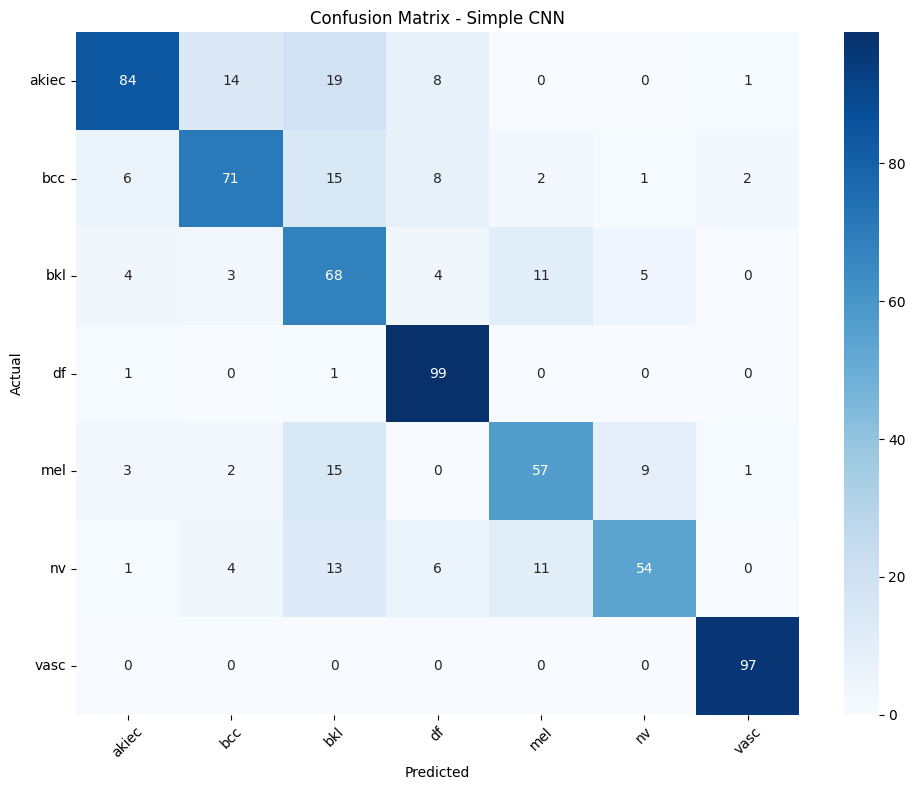

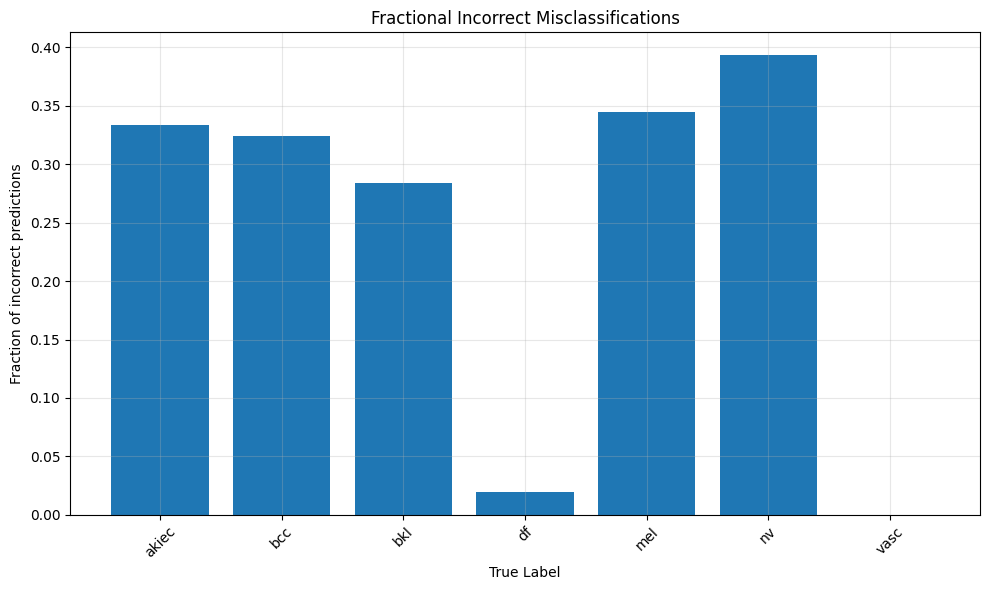


Classification Report:
              precision    recall  f1-score   support

       akiec       0.85      0.67      0.75       126
         bcc       0.76      0.68      0.71       105
         bkl       0.52      0.72      0.60        95
          df       0.79      0.98      0.88       101
         mel       0.70      0.66      0.68        87
          nv       0.78      0.61      0.68        89
        vasc       0.96      1.00      0.98        97

    accuracy                           0.76       700
   macro avg       0.77      0.76      0.75       700
weighted avg       0.77      0.76      0.76       700



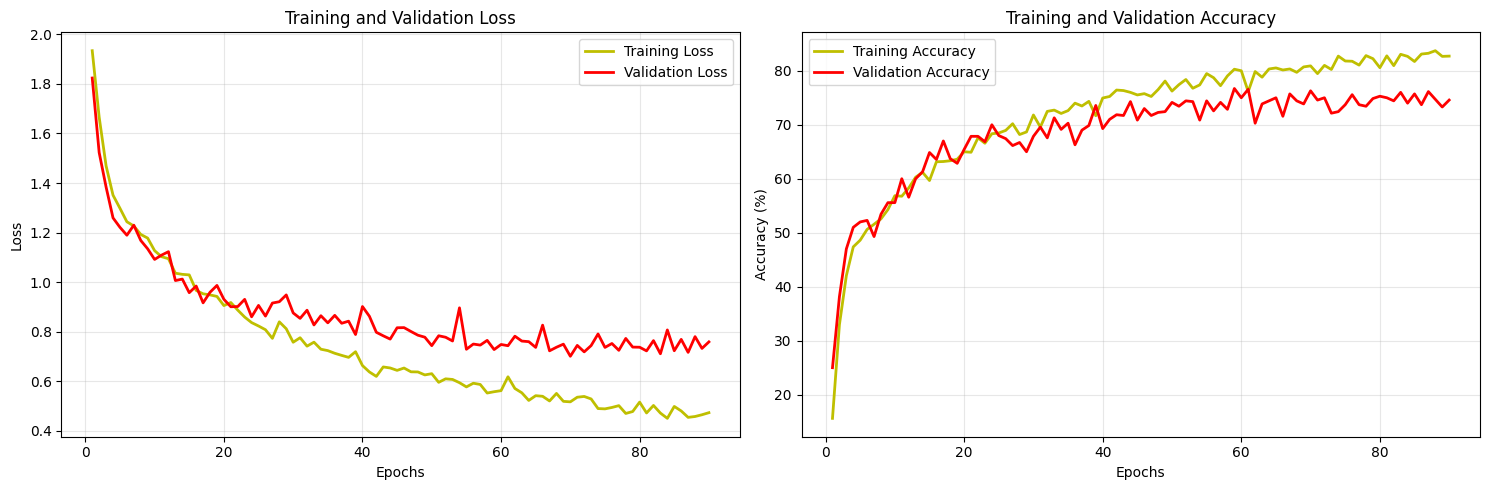

2025/08/22 17:56:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/22 17:56:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/22 17:56:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 90
✅ Best epoch: 70
✅ Final test accuracy: 75.71%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run CNN_Size32_AugFalse_Batch16 at: http://localhost:5000/#/experiments/959049885417408975/runs/aa01b476755d4f328d663bc4eb7b0541
🧪 View experiment at: http://localhost:5000/#/experiments/959049885417408975


In [20]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=150, patience=20, image_size=32, data_augmentation=False, 
    notes="SimpleCNN-500Samples", data_balancing="Resample-500"
)

## 🏋️‍♂️Train ResNet50-500Samples

In [22]:
n_samples = 500  # Samples per class
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

metadata_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced,
                             df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])

image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(input_path, '*', '*.jpg'))}

metadata_balanced['path'] = metadata_balanced['image_id'].map(image_path.get)

SIZE = 224
metadata_balanced['image'] = metadata_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

X = np.asarray(metadata_balanced['image'].tolist())
X = X/255.
Y = metadata_balanced['label']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = torch.FloatTensor(X).permute(0, 3, 1, 2).to(device)
y_tensor = torch.LongTensor(Y.values).to(device)
print(f"Using device: {device}")
print(f"X_tensor shape: {X_tensor.shape}")

x_temp, x_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)


# Create ResNet mmodel
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda
X_tensor shape: torch.Size([3500, 3, 224, 224])
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 39.9MB/s]


Epoch 1/150: 100%|██████████| 132/132 [00:03<00:00, 36.64it/s, loss=1.3581, accuracy=54.67%]


Epoch 1: loss: 1.3273 - accuracy: 54.67% - val_loss: 1.1304 - val_accuracy: 62.00%
Validation loss improved. Best model updated.


Epoch 2/150: 100%|██████████| 132/132 [00:03<00:00, 38.31it/s, loss=0.9048, accuracy=68.95%]


Epoch 2: loss: 0.8842 - accuracy: 68.95% - val_loss: 1.3149 - val_accuracy: 62.29%
No improvement. Patience: 1/20


Epoch 3/150: 100%|██████████| 132/132 [00:03<00:00, 38.18it/s, loss=0.6859, accuracy=75.62%]


Epoch 3: loss: 0.6703 - accuracy: 75.62% - val_loss: 1.1490 - val_accuracy: 63.86%
No improvement. Patience: 2/20


Epoch 4/150: 100%|██████████| 132/132 [00:03<00:00, 39.56it/s, loss=0.5656, accuracy=80.57%]


Epoch 4: loss: 0.5570 - accuracy: 80.57% - val_loss: 0.8845 - val_accuracy: 67.71%
Validation loss improved. Best model updated.


Epoch 5/150: 100%|██████████| 132/132 [00:03<00:00, 38.86it/s, loss=0.4336, accuracy=84.52%]


Epoch 5: loss: 0.4238 - accuracy: 84.52% - val_loss: 0.7072 - val_accuracy: 76.29%
Validation loss improved. Best model updated.


Epoch 6/150: 100%|██████████| 132/132 [00:03<00:00, 38.36it/s, loss=0.3668, accuracy=87.24%]


Epoch 6: loss: 0.3584 - accuracy: 87.24% - val_loss: 1.5394 - val_accuracy: 54.43%
No improvement. Patience: 1/20


Epoch 7/150: 100%|██████████| 132/132 [00:03<00:00, 38.30it/s, loss=0.3209, accuracy=88.57%]


Epoch 7: loss: 0.3136 - accuracy: 88.57% - val_loss: 1.0073 - val_accuracy: 66.29%
No improvement. Patience: 2/20


Epoch 8/150: 100%|██████████| 132/132 [00:03<00:00, 38.14it/s, loss=0.2771, accuracy=90.19%]


Epoch 8: loss: 0.2708 - accuracy: 90.19% - val_loss: 1.0059 - val_accuracy: 68.86%
No improvement. Patience: 3/20


Epoch 9/150: 100%|██████████| 132/132 [00:03<00:00, 38.27it/s, loss=0.1474, accuracy=94.57%]


Epoch 9: loss: 0.1441 - accuracy: 94.57% - val_loss: 0.8308 - val_accuracy: 74.00%
No improvement. Patience: 4/20


Epoch 10/150: 100%|██████████| 132/132 [00:03<00:00, 38.11it/s, loss=0.1558, accuracy=94.19%]


Epoch 10: loss: 0.1522 - accuracy: 94.19% - val_loss: 0.8884 - val_accuracy: 74.57%
No improvement. Patience: 5/20


Epoch 11/150: 100%|██████████| 132/132 [00:03<00:00, 38.73it/s, loss=0.1283, accuracy=95.48%]


Epoch 11: loss: 0.1263 - accuracy: 95.48% - val_loss: 0.8636 - val_accuracy: 75.86%
No improvement. Patience: 6/20


Epoch 12/150: 100%|██████████| 132/132 [00:03<00:00, 38.21it/s, loss=0.0904, accuracy=97.24%]


Epoch 12: loss: 0.0883 - accuracy: 97.24% - val_loss: 1.1965 - val_accuracy: 68.29%
No improvement. Patience: 7/20


Epoch 13/150: 100%|██████████| 132/132 [00:03<00:00, 38.44it/s, loss=0.1295, accuracy=95.95%]


Epoch 13: loss: 0.1266 - accuracy: 95.95% - val_loss: 1.2024 - val_accuracy: 68.86%
No improvement. Patience: 8/20


Epoch 14/150: 100%|██████████| 132/132 [00:03<00:00, 38.45it/s, loss=0.0915, accuracy=97.14%]


Epoch 14: loss: 0.0894 - accuracy: 97.14% - val_loss: 0.8864 - val_accuracy: 74.29%
No improvement. Patience: 9/20


Epoch 15/150: 100%|██████████| 132/132 [00:03<00:00, 38.24it/s, loss=0.0495, accuracy=98.71%]


Epoch 15: loss: 0.0484 - accuracy: 98.71% - val_loss: 1.7650 - val_accuracy: 69.43%
No improvement. Patience: 10/20


Epoch 16/150: 100%|██████████| 132/132 [00:03<00:00, 37.68it/s, loss=0.0842, accuracy=97.52%]


Epoch 16: loss: 0.0823 - accuracy: 97.52% - val_loss: 1.1640 - val_accuracy: 67.29%
No improvement. Patience: 11/20


Epoch 17/150: 100%|██████████| 132/132 [00:03<00:00, 38.29it/s, loss=0.0718, accuracy=97.43%]


Epoch 17: loss: 0.0702 - accuracy: 97.43% - val_loss: 0.9521 - val_accuracy: 75.86%
No improvement. Patience: 12/20


Epoch 18/150: 100%|██████████| 132/132 [00:03<00:00, 38.44it/s, loss=0.1166, accuracy=96.33%]


Epoch 18: loss: 0.1148 - accuracy: 96.33% - val_loss: 1.4050 - val_accuracy: 67.71%
No improvement. Patience: 13/20


Epoch 19/150: 100%|██████████| 132/132 [00:03<00:00, 38.76it/s, loss=0.0647, accuracy=98.10%]


Epoch 19: loss: 0.0632 - accuracy: 98.10% - val_loss: 0.7858 - val_accuracy: 80.14%
No improvement. Patience: 14/20


Epoch 20/150: 100%|██████████| 132/132 [00:03<00:00, 38.56it/s, loss=0.0835, accuracy=97.48%]


Epoch 20: loss: 0.0816 - accuracy: 97.48% - val_loss: 1.0943 - val_accuracy: 68.71%
No improvement. Patience: 15/20


Epoch 21/150: 100%|██████████| 132/132 [00:03<00:00, 38.73it/s, loss=0.1078, accuracy=96.76%]


Epoch 21: loss: 0.1054 - accuracy: 96.76% - val_loss: 1.0671 - val_accuracy: 70.43%
No improvement. Patience: 16/20


Epoch 22/150: 100%|██████████| 132/132 [00:03<00:00, 38.73it/s, loss=0.1109, accuracy=96.48%]


Epoch 22: loss: 0.1084 - accuracy: 96.48% - val_loss: 0.8173 - val_accuracy: 79.57%
No improvement. Patience: 17/20


Epoch 23/150: 100%|██████████| 132/132 [00:03<00:00, 38.34it/s, loss=0.0363, accuracy=99.05%]


Epoch 23: loss: 0.0355 - accuracy: 99.05% - val_loss: 0.7700 - val_accuracy: 82.14%
No improvement. Patience: 18/20


Epoch 24/150: 100%|██████████| 132/132 [00:03<00:00, 37.95it/s, loss=0.0282, accuracy=98.95%]


Epoch 24: loss: 0.0276 - accuracy: 98.95% - val_loss: 1.0649 - val_accuracy: 76.86%
No improvement. Patience: 19/20


Epoch 25/150: 100%|██████████| 132/132 [00:03<00:00, 38.48it/s, loss=0.0411, accuracy=98.81%]


Epoch 25: loss: 0.0402 - accuracy: 98.81% - val_loss: 0.8102 - val_accuracy: 79.43%
No improvement. Patience: 20/20
Early stopping triggered after 25 epochs
Best model from epoch 5 loaded

Test Results:
Test Loss: 1.1240
Test Accuracy: 78.71%


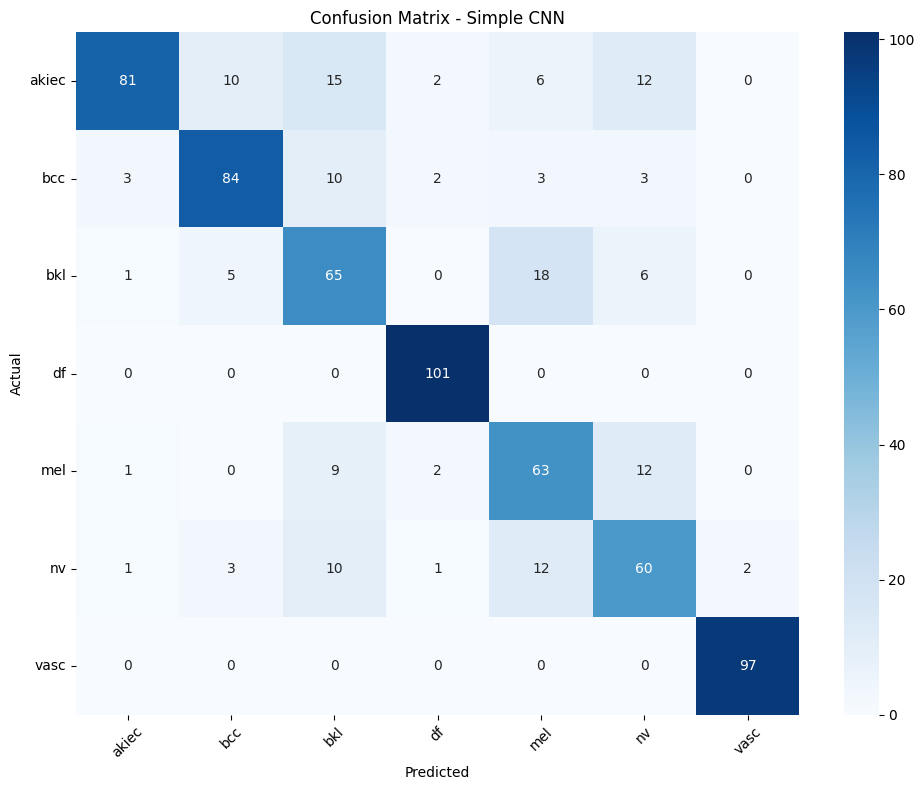

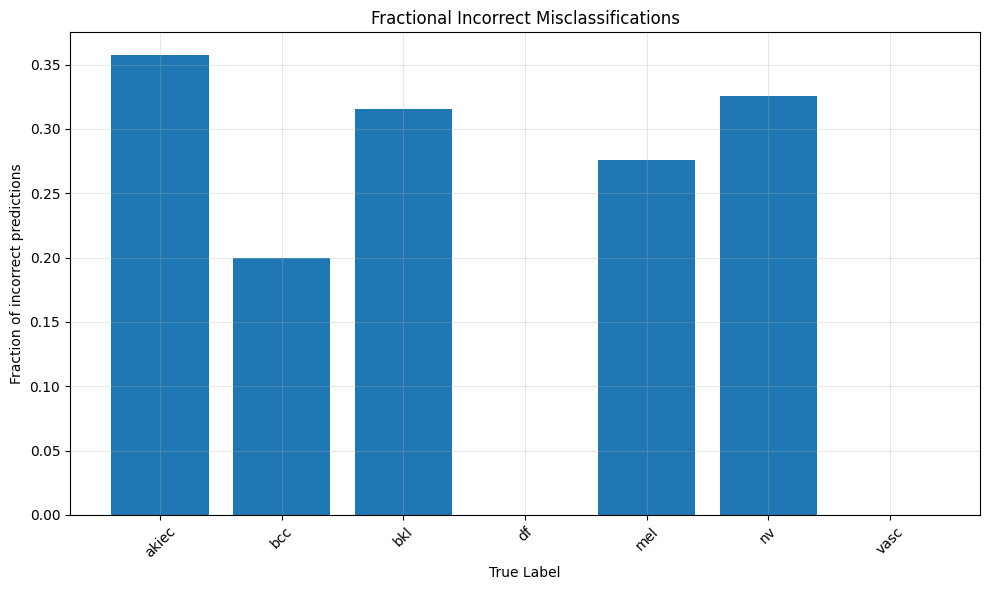


Classification Report:
              precision    recall  f1-score   support

       akiec       0.93      0.64      0.76       126
         bcc       0.82      0.80      0.81       105
         bkl       0.60      0.68      0.64        95
          df       0.94      1.00      0.97       101
         mel       0.62      0.72      0.67        87
          nv       0.65      0.67      0.66        89
        vasc       0.98      1.00      0.99        97

    accuracy                           0.79       700
   macro avg       0.79      0.79      0.78       700
weighted avg       0.80      0.79      0.79       700



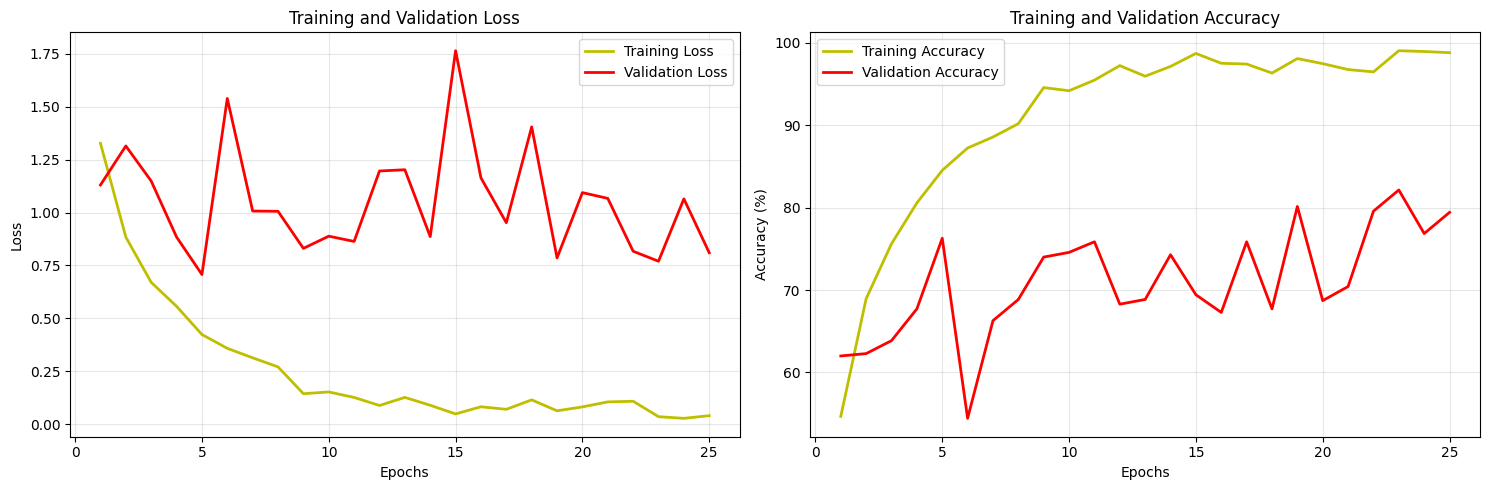

2025/08/22 17:59:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/22 17:59:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/22 17:59:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 25
✅ Best epoch: 5
✅ Final test accuracy: 78.71%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run ResNet_Size224_AugFalse_Batch16 at: http://localhost:5000/#/experiments/959049885417408975/runs/bf7b57d80ee94902b6fc3aa548655dfb
🧪 View experiment at: http://localhost:5000/#/experiments/959049885417408975


In [23]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=150, patience=20, image_size=224, data_augmentation=False,
    notes="ResNet50-500Samples", data_balancing="Resample-500"
)

## 🏋️‍♂️Train ResNet50-DA-500Samples

DA : Data Augmentation

In [24]:
n_samples = 500  # Samples per class
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

metadata_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced,
                             df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])

image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(input_path, '*', '*.jpg'))}

metadata_balanced['path'] = metadata_balanced['image_id'].map(image_path.get)

input_size = 224
norm_mean = [0.485, 0.456, 0.406]  # ImageNet means
norm_std = [0.229, 0.224, 0.225]   # ImageNet stds

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_df, test_df = train_test_split(metadata_balanced, test_size=0.2, random_state=42, stratify=metadata_balanced['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])


# Create custom dataset class
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']

        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets with transforms
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Create ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/150: 100%|██████████| 132/132 [00:26<00:00,  5.02it/s, loss=1.5418, accuracy=42.86%]


Epoch 1: loss: 1.5418 - accuracy: 42.86% - val_loss: 1.7613 - val_accuracy: 44.29%
Validation loss improved. Best model updated.


Epoch 2/150: 100%|██████████| 132/132 [00:27<00:00,  4.87it/s, loss=1.2166, accuracy=55.81%]


Epoch 2: loss: 1.2166 - accuracy: 55.81% - val_loss: 1.2024 - val_accuracy: 57.29%
Validation loss improved. Best model updated.


Epoch 3/150: 100%|██████████| 132/132 [00:27<00:00,  4.86it/s, loss=1.1041, accuracy=59.43%]


Epoch 3: loss: 1.1041 - accuracy: 59.43% - val_loss: 1.4023 - val_accuracy: 52.14%
No improvement. Patience: 1/20


Epoch 4/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.9948, accuracy=62.81%]


Epoch 4: loss: 0.9948 - accuracy: 62.81% - val_loss: 1.0407 - val_accuracy: 62.71%
Validation loss improved. Best model updated.


Epoch 5/150: 100%|██████████| 132/132 [00:26<00:00,  4.89it/s, loss=0.9124, accuracy=65.86%]


Epoch 5: loss: 0.9124 - accuracy: 65.86% - val_loss: 0.9309 - val_accuracy: 64.57%
Validation loss improved. Best model updated.


Epoch 6/150: 100%|██████████| 132/132 [00:26<00:00,  4.93it/s, loss=0.8480, accuracy=68.62%]


Epoch 6: loss: 0.8480 - accuracy: 68.62% - val_loss: 0.7893 - val_accuracy: 69.86%
Validation loss improved. Best model updated.


Epoch 7/150: 100%|██████████| 132/132 [00:26<00:00,  4.97it/s, loss=0.8383, accuracy=68.52%]


Epoch 7: loss: 0.8383 - accuracy: 68.52% - val_loss: 0.8393 - val_accuracy: 71.71%
No improvement. Patience: 1/20


Epoch 8/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.8259, accuracy=69.90%]


Epoch 8: loss: 0.8259 - accuracy: 69.90% - val_loss: 0.7075 - val_accuracy: 74.57%
Validation loss improved. Best model updated.


Epoch 9/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.7531, accuracy=72.05%]


Epoch 9: loss: 0.7531 - accuracy: 72.05% - val_loss: 0.8540 - val_accuracy: 71.14%
No improvement. Patience: 1/20


Epoch 10/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.7088, accuracy=73.95%]


Epoch 10: loss: 0.7088 - accuracy: 73.95% - val_loss: 0.7276 - val_accuracy: 75.14%
No improvement. Patience: 2/20


Epoch 11/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.6864, accuracy=75.14%]


Epoch 11: loss: 0.6864 - accuracy: 75.14% - val_loss: 0.9966 - val_accuracy: 66.29%
No improvement. Patience: 3/20


Epoch 12/150: 100%|██████████| 132/132 [00:26<00:00,  4.99it/s, loss=0.6564, accuracy=75.95%]


Epoch 12: loss: 0.6564 - accuracy: 75.95% - val_loss: 0.7096 - val_accuracy: 75.43%
No improvement. Patience: 4/20


Epoch 13/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.6613, accuracy=76.33%]


Epoch 13: loss: 0.6613 - accuracy: 76.33% - val_loss: 0.7974 - val_accuracy: 73.71%
No improvement. Patience: 5/20


Epoch 14/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.6194, accuracy=77.24%]


Epoch 14: loss: 0.6194 - accuracy: 77.24% - val_loss: 0.7461 - val_accuracy: 74.86%
No improvement. Patience: 6/20


Epoch 15/150: 100%|██████████| 132/132 [00:26<00:00,  4.97it/s, loss=0.5589, accuracy=78.57%]


Epoch 15: loss: 0.5589 - accuracy: 78.57% - val_loss: 1.0002 - val_accuracy: 67.43%
No improvement. Patience: 7/20


Epoch 16/150: 100%|██████████| 132/132 [00:26<00:00,  4.98it/s, loss=0.6217, accuracy=76.52%]


Epoch 16: loss: 0.6217 - accuracy: 76.52% - val_loss: 0.8304 - val_accuracy: 75.29%
No improvement. Patience: 8/20


Epoch 17/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.5446, accuracy=80.62%]


Epoch 17: loss: 0.5446 - accuracy: 80.62% - val_loss: 0.6865 - val_accuracy: 76.57%
Validation loss improved. Best model updated.


Epoch 18/150: 100%|██████████| 132/132 [00:26<00:00,  5.05it/s, loss=0.5220, accuracy=81.05%]


Epoch 18: loss: 0.5220 - accuracy: 81.05% - val_loss: 0.6966 - val_accuracy: 76.57%
No improvement. Patience: 1/20


Epoch 19/150: 100%|██████████| 132/132 [00:26<00:00,  4.98it/s, loss=0.5261, accuracy=81.10%]


Epoch 19: loss: 0.5261 - accuracy: 81.10% - val_loss: 0.8594 - val_accuracy: 75.71%
No improvement. Patience: 2/20


Epoch 20/150: 100%|██████████| 132/132 [00:25<00:00,  5.11it/s, loss=0.5329, accuracy=79.81%]


Epoch 20: loss: 0.5329 - accuracy: 79.81% - val_loss: 0.6455 - val_accuracy: 76.00%
Validation loss improved. Best model updated.


Epoch 21/150: 100%|██████████| 132/132 [00:26<00:00,  4.98it/s, loss=0.4691, accuracy=82.81%]


Epoch 21: loss: 0.4691 - accuracy: 82.81% - val_loss: 0.7744 - val_accuracy: 73.86%
No improvement. Patience: 1/20


Epoch 22/150: 100%|██████████| 132/132 [00:26<00:00,  4.99it/s, loss=0.4746, accuracy=82.57%]


Epoch 22: loss: 0.4746 - accuracy: 82.57% - val_loss: 0.7445 - val_accuracy: 76.86%
No improvement. Patience: 2/20


Epoch 23/150: 100%|██████████| 132/132 [00:26<00:00,  4.95it/s, loss=0.4662, accuracy=82.62%]


Epoch 23: loss: 0.4662 - accuracy: 82.62% - val_loss: 0.5325 - val_accuracy: 82.86%
Validation loss improved. Best model updated.


Epoch 24/150: 100%|██████████| 132/132 [00:26<00:00,  4.97it/s, loss=0.4022, accuracy=85.33%]


Epoch 24: loss: 0.4022 - accuracy: 85.33% - val_loss: 0.7257 - val_accuracy: 76.00%
No improvement. Patience: 1/20


Epoch 25/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.3989, accuracy=85.29%]


Epoch 25: loss: 0.3989 - accuracy: 85.29% - val_loss: 0.6111 - val_accuracy: 79.14%
No improvement. Patience: 2/20


Epoch 26/150: 100%|██████████| 132/132 [00:26<00:00,  4.92it/s, loss=0.3971, accuracy=86.43%]


Epoch 26: loss: 0.3971 - accuracy: 86.43% - val_loss: 0.5932 - val_accuracy: 79.29%
No improvement. Patience: 3/20


Epoch 27/150: 100%|██████████| 132/132 [00:26<00:00,  4.95it/s, loss=0.3765, accuracy=86.90%]


Epoch 27: loss: 0.3765 - accuracy: 86.90% - val_loss: 0.7288 - val_accuracy: 78.86%
No improvement. Patience: 4/20


Epoch 28/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.3517, accuracy=87.67%]


Epoch 28: loss: 0.3517 - accuracy: 87.67% - val_loss: 0.6164 - val_accuracy: 80.29%
No improvement. Patience: 5/20


Epoch 29/150: 100%|██████████| 132/132 [00:26<00:00,  4.95it/s, loss=0.3488, accuracy=87.14%]


Epoch 29: loss: 0.3488 - accuracy: 87.14% - val_loss: 0.6563 - val_accuracy: 80.14%
No improvement. Patience: 6/20


Epoch 30/150: 100%|██████████| 132/132 [00:26<00:00,  4.98it/s, loss=0.3680, accuracy=86.67%]


Epoch 30: loss: 0.3680 - accuracy: 86.67% - val_loss: 0.6620 - val_accuracy: 78.71%
No improvement. Patience: 7/20


Epoch 31/150: 100%|██████████| 132/132 [00:26<00:00,  4.95it/s, loss=0.3455, accuracy=87.52%]


Epoch 31: loss: 0.3455 - accuracy: 87.52% - val_loss: 0.5616 - val_accuracy: 82.57%
No improvement. Patience: 8/20


Epoch 32/150: 100%|██████████| 132/132 [00:26<00:00,  4.92it/s, loss=0.3257, accuracy=88.05%]


Epoch 32: loss: 0.3257 - accuracy: 88.05% - val_loss: 0.5960 - val_accuracy: 82.57%
No improvement. Patience: 9/20


Epoch 33/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.3153, accuracy=87.81%]


Epoch 33: loss: 0.3153 - accuracy: 87.81% - val_loss: 0.6763 - val_accuracy: 78.29%
No improvement. Patience: 10/20


Epoch 34/150: 100%|██████████| 132/132 [00:26<00:00,  5.01it/s, loss=0.2850, accuracy=89.43%]


Epoch 34: loss: 0.2850 - accuracy: 89.43% - val_loss: 0.5626 - val_accuracy: 81.71%
No improvement. Patience: 11/20


Epoch 35/150: 100%|██████████| 132/132 [00:26<00:00,  4.99it/s, loss=0.3070, accuracy=88.95%]


Epoch 35: loss: 0.3070 - accuracy: 88.95% - val_loss: 0.6929 - val_accuracy: 80.86%
No improvement. Patience: 12/20


Epoch 36/150: 100%|██████████| 132/132 [00:29<00:00,  4.51it/s, loss=0.2683, accuracy=90.48%]


Epoch 36: loss: 0.2683 - accuracy: 90.48% - val_loss: 0.5935 - val_accuracy: 81.29%
No improvement. Patience: 13/20


Epoch 37/150: 100%|██████████| 132/132 [00:28<00:00,  4.56it/s, loss=0.2818, accuracy=90.05%]


Epoch 37: loss: 0.2818 - accuracy: 90.05% - val_loss: 0.6444 - val_accuracy: 80.57%
No improvement. Patience: 14/20


Epoch 38/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.3246, accuracy=88.57%]


Epoch 38: loss: 0.3246 - accuracy: 88.57% - val_loss: 0.7106 - val_accuracy: 78.14%
No improvement. Patience: 15/20


Epoch 39/150: 100%|██████████| 132/132 [00:26<00:00,  4.95it/s, loss=0.2459, accuracy=91.48%]


Epoch 39: loss: 0.2459 - accuracy: 91.48% - val_loss: 0.6181 - val_accuracy: 82.71%
No improvement. Patience: 16/20


Epoch 40/150: 100%|██████████| 132/132 [00:26<00:00,  4.96it/s, loss=0.2593, accuracy=90.10%]


Epoch 40: loss: 0.2593 - accuracy: 90.10% - val_loss: 0.6161 - val_accuracy: 82.29%
No improvement. Patience: 17/20


Epoch 41/150: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s, loss=0.2325, accuracy=91.19%]


Epoch 41: loss: 0.2325 - accuracy: 91.19% - val_loss: 0.5869 - val_accuracy: 82.14%
No improvement. Patience: 18/20


Epoch 42/150: 100%|██████████| 132/132 [00:26<00:00,  4.95it/s, loss=0.2213, accuracy=92.10%]


Epoch 42: loss: 0.2213 - accuracy: 92.10% - val_loss: 0.6822 - val_accuracy: 82.29%
No improvement. Patience: 19/20


Epoch 43/150: 100%|██████████| 132/132 [00:26<00:00,  4.91it/s, loss=0.2092, accuracy=92.33%]


Epoch 43: loss: 0.2092 - accuracy: 92.33% - val_loss: 0.7632 - val_accuracy: 81.43%
No improvement. Patience: 20/20
Early stopping triggered after 43 epochs
Best model from epoch 23 loaded

Test Results:
Test Loss: 0.7219
Test Accuracy: 82.71%


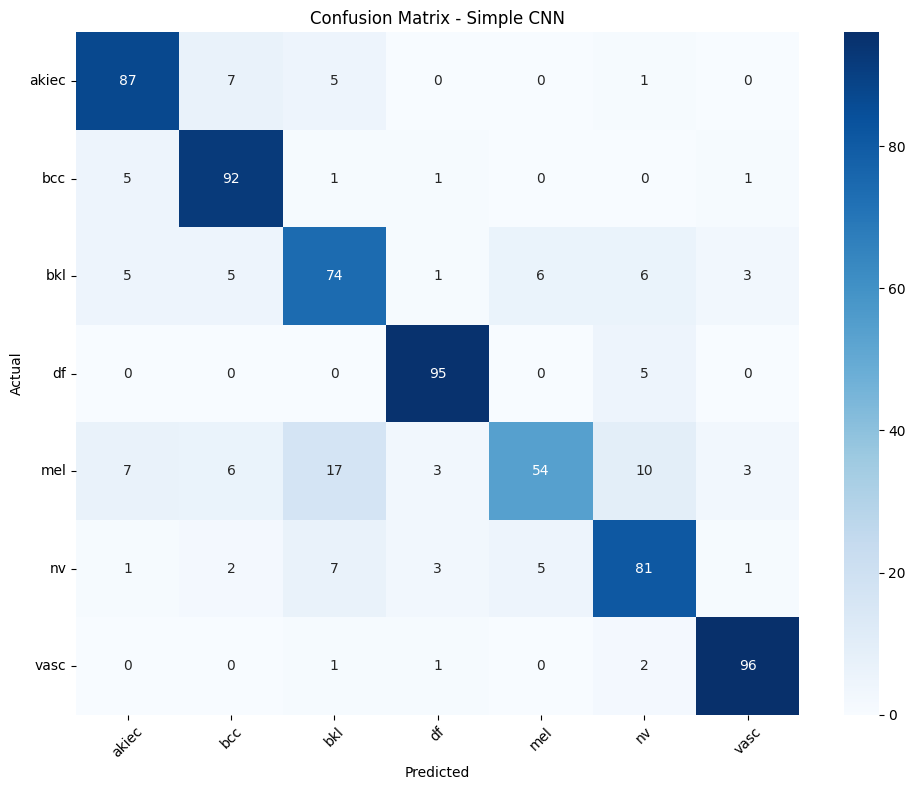

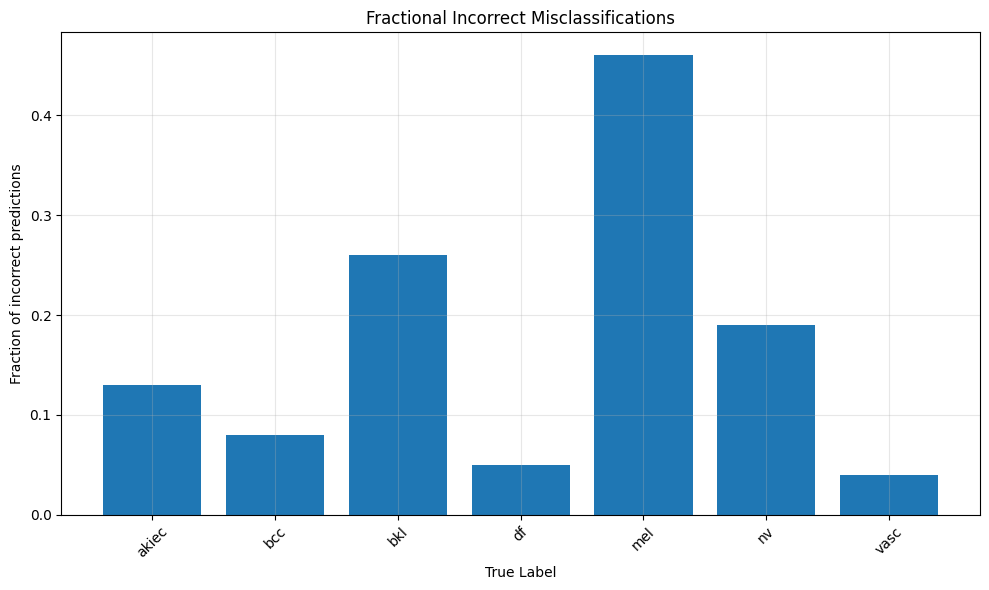


Classification Report:
              precision    recall  f1-score   support

       akiec       0.83      0.87      0.85       100
         bcc       0.82      0.92      0.87       100
         bkl       0.70      0.74      0.72       100
          df       0.91      0.95      0.93       100
         mel       0.83      0.54      0.65       100
          nv       0.77      0.81      0.79       100
        vasc       0.92      0.96      0.94       100

    accuracy                           0.83       700
   macro avg       0.83      0.83      0.82       700
weighted avg       0.83      0.83      0.82       700



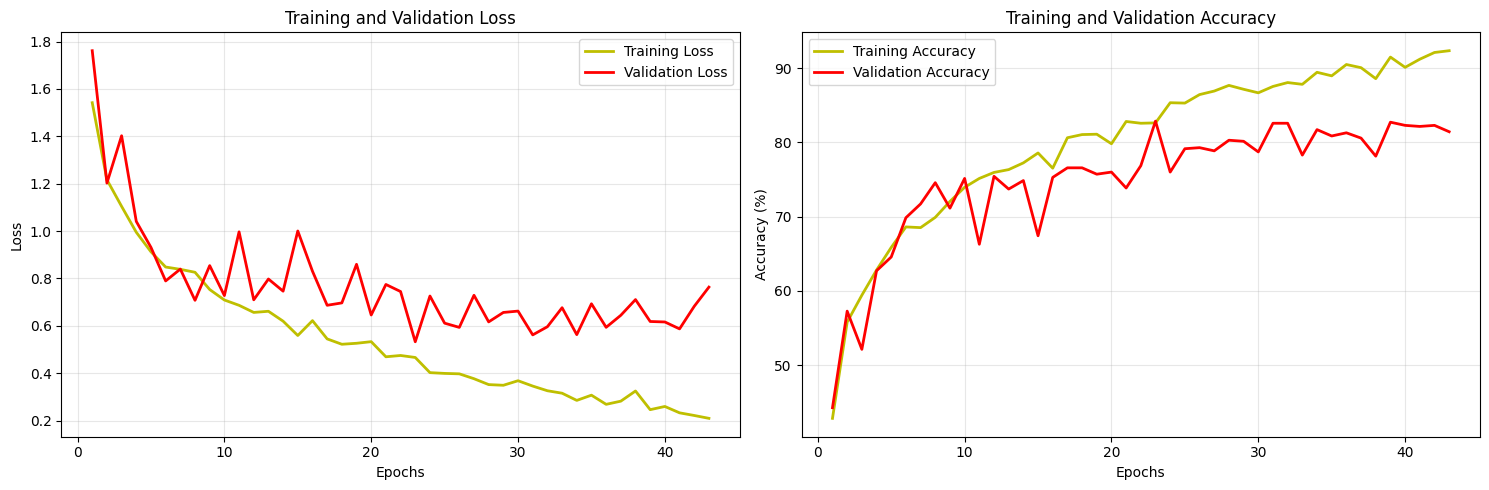

2025/08/22 18:23:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/22 18:23:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/22 18:23:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 43
✅ Best epoch: 23
✅ Final test accuracy: 82.71%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run ResNet_Size224_AugTrue_Batch16 at: http://localhost:5000/#/experiments/959049885417408975/runs/c8d59dd6fbd54e69a75901c2250582e4
🧪 View experiment at: http://localhost:5000/#/experiments/959049885417408975


In [25]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=150, patience=20, image_size=224, data_augmentation=True,
    notes="ResNet50-DA-500Samples", data_balancing="Resample-500"
)

## 🏋️‍♂️Train ResNet50-DA-ClassAug

Instead of forcing all classes to the same size (500 approach), were are going to use class-specific multiplication rates:
- Small classes get big multipliers: df × 50, akiec × 15, vasc × 40
- Large classes get small multipliers: nv × 1 (unchanged)
- Medium classes get medium multipliers: bcc × 10, mel × 5

In [26]:
metadata = pd.read_csv(os.path.join(input_path, "HAM10000_metadata.csv"))

label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
print("Imbalanced dataset distribution:")
print(metadata['label'].value_counts())

# different multipliers per class
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]
df_0 = metadata[metadata['label'] == 0]  # akiec
df_1 = metadata[metadata['label'] == 1]  # bcc
df_2 = metadata[metadata['label'] == 2]  # bkl
df_3 = metadata[metadata['label'] == 3]  # df
df_4 = metadata[metadata['label'] == 4]  # mel
df_5 = metadata[metadata['label'] == 5]  # nv
df_6 = metadata[metadata['label'] == 6]  # vasc

dfs = [df_0, df_1, df_2, df_3, df_4, df_5, df_6]
balanced_dfs = []

for i, (df_class, rate) in enumerate(zip(dfs, data_aug_rate)):
    if rate > 0:
        # Multiply the class by the rate
        augmented_df = pd.concat([df_class] * rate, ignore_index=True)
        balanced_dfs.append(augmented_df)
    else:
        # Rate 0 means use original
        balanced_dfs.append(df_class)

metadata_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("Balanced dataset distribution:")
print(metadata_balanced['label'].value_counts().sort_index())

Imbalanced dataset distribution:
label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
Balanced dataset distribution:
label
0    4905
1    5140
2    5495
3    5750
4    5565
5    6705
6    5680
Name: count, dtype: int64


In [27]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(input_path, '*', '*.jpg'))}
metadata_balanced['path'] = metadata_balanced['image_id'].map(image_path.get)

# Set up transforms
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_df, test_df = train_test_split(metadata_balanced, test_size=0.2, random_state=42, stratify=metadata_balanced['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])

# Create custom dataset class
class SkinDataset(Dataset):
   def __init__(self, dataframe, transform=None):
       self.df = dataframe.reset_index(drop=True)
       # Pre-extract paths and labels for faster access
       self.image_paths = dataframe['path'].values
       self.labels = dataframe['label'].values
       self.transform = transform

   def __len__(self):
       return len(self.df)

   def __getitem__(self, idx):
       image_path = self.image_paths[idx]  # Fast numpy array access
       label = self.labels[idx]            # Fast numpy array access

       image = Image.open(image_path)

       if self.transform:
           image = self.transform(image)

       return image, label

# Create datasets with transforms
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

# Enable PyTorch optimizations
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,              # 2x larger (or 128 if GPU memory allows)
    shuffle=True,
    num_workers=8,              # 2x more workers
    pin_memory=True,            # Speeds up CPU->GPU transfer
    persistent_workers=True,    # Keeps workers alive between epochs
    prefetch_factor=4           # Prefetch multiple batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,             # Even larger for validation (no gradients)
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,             # Larger batch
    shuffle=False,
    num_workers=4,              # Keep moderate
    pin_memory=True             # No persistent_workers for one-time use
)
# Create ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50: 100%|██████████| 368/368 [00:44<00:00,  8.20it/s, loss=0.7355, accuracy=72.72%]


Epoch 1: loss: 0.7355 - accuracy: 72.72% - val_loss: 0.6444 - val_accuracy: 76.83%
Validation loss improved. Best model updated.


Epoch 2/50: 100%|██████████| 368/368 [00:39<00:00,  9.29it/s, loss=0.4639, accuracy=82.55%]


Epoch 2: loss: 0.4639 - accuracy: 82.55% - val_loss: 0.4835 - val_accuracy: 82.87%
Validation loss improved. Best model updated.


Epoch 3/50: 100%|██████████| 368/368 [00:39<00:00,  9.29it/s, loss=0.3658, accuracy=86.29%]


Epoch 3: loss: 0.3658 - accuracy: 86.29% - val_loss: 0.4210 - val_accuracy: 83.69%
Validation loss improved. Best model updated.


Epoch 4/50: 100%|██████████| 368/368 [00:39<00:00,  9.35it/s, loss=0.3008, accuracy=88.57%]


Epoch 4: loss: 0.3008 - accuracy: 88.57% - val_loss: 0.2914 - val_accuracy: 89.19%
Validation loss improved. Best model updated.


Epoch 5/50: 100%|██████████| 368/368 [00:39<00:00,  9.34it/s, loss=0.2671, accuracy=89.68%]


Epoch 5: loss: 0.2671 - accuracy: 89.68% - val_loss: 0.2879 - val_accuracy: 89.82%
Validation loss improved. Best model updated.


Epoch 6/50: 100%|██████████| 368/368 [00:39<00:00,  9.36it/s, loss=0.2354, accuracy=91.22%]


Epoch 6: loss: 0.2354 - accuracy: 91.22% - val_loss: 0.1837 - val_accuracy: 92.92%
Validation loss improved. Best model updated.


Epoch 7/50: 100%|██████████| 368/368 [00:39<00:00,  9.41it/s, loss=0.2102, accuracy=92.04%]


Epoch 7: loss: 0.2102 - accuracy: 92.04% - val_loss: 0.2276 - val_accuracy: 91.45%
No improvement. Patience: 1/10


Epoch 8/50: 100%|██████████| 368/368 [00:39<00:00,  9.38it/s, loss=0.1864, accuracy=92.92%]


Epoch 8: loss: 0.1864 - accuracy: 92.92% - val_loss: 0.1665 - val_accuracy: 93.91%
Validation loss improved. Best model updated.


Epoch 9/50: 100%|██████████| 368/368 [00:39<00:00,  9.35it/s, loss=0.1689, accuracy=93.56%]


Epoch 9: loss: 0.1689 - accuracy: 93.56% - val_loss: 0.2084 - val_accuracy: 92.99%
No improvement. Patience: 1/10


Epoch 10/50: 100%|██████████| 368/368 [00:39<00:00,  9.39it/s, loss=0.1515, accuracy=94.36%]


Epoch 10: loss: 0.1515 - accuracy: 94.36% - val_loss: 0.1501 - val_accuracy: 94.42%
Validation loss improved. Best model updated.


Epoch 11/50: 100%|██████████| 368/368 [00:39<00:00,  9.29it/s, loss=0.1402, accuracy=94.84%]


Epoch 11: loss: 0.1402 - accuracy: 94.84% - val_loss: 0.2653 - val_accuracy: 91.27%
No improvement. Patience: 1/10


Epoch 12/50: 100%|██████████| 368/368 [00:39<00:00,  9.32it/s, loss=0.1268, accuracy=95.37%]


Epoch 12: loss: 0.1268 - accuracy: 95.37% - val_loss: 0.1775 - val_accuracy: 93.73%
No improvement. Patience: 2/10


Epoch 13/50: 100%|██████████| 368/368 [00:39<00:00,  9.30it/s, loss=0.1199, accuracy=95.66%]


Epoch 13: loss: 0.1199 - accuracy: 95.66% - val_loss: 0.1360 - val_accuracy: 95.29%
Validation loss improved. Best model updated.


Epoch 14/50: 100%|██████████| 368/368 [00:39<00:00,  9.39it/s, loss=0.1034, accuracy=96.11%]


Epoch 14: loss: 0.1034 - accuracy: 96.11% - val_loss: 0.2724 - val_accuracy: 91.07%
No improvement. Patience: 1/10


Epoch 15/50: 100%|██████████| 368/368 [00:39<00:00,  9.27it/s, loss=0.1066, accuracy=96.20%]


Epoch 15: loss: 0.1066 - accuracy: 96.20% - val_loss: 0.1493 - val_accuracy: 95.03%
No improvement. Patience: 2/10


Epoch 16/50: 100%|██████████| 368/368 [00:39<00:00,  9.36it/s, loss=0.0947, accuracy=96.69%]


Epoch 16: loss: 0.0947 - accuracy: 96.69% - val_loss: 0.1376 - val_accuracy: 95.15%
No improvement. Patience: 3/10


Epoch 17/50: 100%|██████████| 368/368 [00:39<00:00,  9.40it/s, loss=0.0969, accuracy=96.50%]


Epoch 17: loss: 0.0969 - accuracy: 96.50% - val_loss: 0.1128 - val_accuracy: 96.39%
Validation loss improved. Best model updated.


Epoch 18/50: 100%|██████████| 368/368 [00:39<00:00,  9.34it/s, loss=0.0846, accuracy=96.88%]


Epoch 18: loss: 0.0846 - accuracy: 96.88% - val_loss: 0.1054 - val_accuracy: 96.44%
Validation loss improved. Best model updated.


Epoch 19/50: 100%|██████████| 368/368 [00:39<00:00,  9.37it/s, loss=0.0750, accuracy=97.26%]


Epoch 19: loss: 0.0750 - accuracy: 97.26% - val_loss: 0.1104 - val_accuracy: 96.28%
No improvement. Patience: 1/10


Epoch 20/50: 100%|██████████| 368/368 [00:39<00:00,  9.40it/s, loss=0.0717, accuracy=97.46%]


Epoch 20: loss: 0.0717 - accuracy: 97.46% - val_loss: 0.0940 - val_accuracy: 96.99%
Validation loss improved. Best model updated.


Epoch 21/50: 100%|██████████| 368/368 [00:39<00:00,  9.39it/s, loss=0.0744, accuracy=97.35%]


Epoch 21: loss: 0.0744 - accuracy: 97.35% - val_loss: 0.1138 - val_accuracy: 96.22%
No improvement. Patience: 1/10


Epoch 22/50: 100%|██████████| 368/368 [00:39<00:00,  9.37it/s, loss=0.0629, accuracy=97.83%]


Epoch 22: loss: 0.0629 - accuracy: 97.83% - val_loss: 0.1106 - val_accuracy: 96.70%
No improvement. Patience: 2/10


Epoch 23/50: 100%|██████████| 368/368 [00:39<00:00,  9.33it/s, loss=0.0689, accuracy=97.50%]


Epoch 23: loss: 0.0689 - accuracy: 97.50% - val_loss: 0.0966 - val_accuracy: 96.80%
No improvement. Patience: 3/10


Epoch 24/50: 100%|██████████| 368/368 [00:40<00:00,  9.20it/s, loss=0.0571, accuracy=98.00%]


Epoch 24: loss: 0.0571 - accuracy: 98.00% - val_loss: 0.0950 - val_accuracy: 96.90%
No improvement. Patience: 4/10


Epoch 25/50: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.0552, accuracy=98.03%]


Epoch 25: loss: 0.0551 - accuracy: 98.03% - val_loss: 0.1073 - val_accuracy: 96.71%
No improvement. Patience: 5/10


Epoch 26/50: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.0492, accuracy=98.22%]


Epoch 26: loss: 0.0492 - accuracy: 98.22% - val_loss: 0.0774 - val_accuracy: 97.80%
Validation loss improved. Best model updated.


Epoch 27/50: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.0490, accuracy=98.22%]


Epoch 27: loss: 0.0490 - accuracy: 98.22% - val_loss: 0.1008 - val_accuracy: 96.83%
No improvement. Patience: 1/10


Epoch 28/50: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.0532, accuracy=98.14%]


Epoch 28: loss: 0.0532 - accuracy: 98.14% - val_loss: 0.0958 - val_accuracy: 97.15%
No improvement. Patience: 2/10


Epoch 29/50: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.0533, accuracy=98.23%]


Epoch 29: loss: 0.0533 - accuracy: 98.23% - val_loss: 0.0929 - val_accuracy: 97.31%
No improvement. Patience: 3/10


Epoch 30/50: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.0448, accuracy=98.40%]


Epoch 30: loss: 0.0448 - accuracy: 98.40% - val_loss: 0.0834 - val_accuracy: 97.52%
No improvement. Patience: 4/10


Epoch 31/50: 100%|██████████| 368/368 [00:40<00:00,  9.13it/s, loss=0.0375, accuracy=98.59%]


Epoch 31: loss: 0.0375 - accuracy: 98.59% - val_loss: 0.0934 - val_accuracy: 97.36%
No improvement. Patience: 5/10


Epoch 32/50: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.0451, accuracy=98.41%]


Epoch 32: loss: 0.0451 - accuracy: 98.41% - val_loss: 0.0842 - val_accuracy: 97.39%
No improvement. Patience: 6/10


Epoch 33/50: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.0456, accuracy=98.42%]


Epoch 33: loss: 0.0456 - accuracy: 98.42% - val_loss: 0.1044 - val_accuracy: 96.66%
No improvement. Patience: 7/10


Epoch 34/50: 100%|██████████| 368/368 [00:39<00:00,  9.39it/s, loss=0.0368, accuracy=98.73%]


Epoch 34: loss: 0.0368 - accuracy: 98.73% - val_loss: 0.0945 - val_accuracy: 97.53%
No improvement. Patience: 8/10


Epoch 35/50: 100%|██████████| 368/368 [00:39<00:00,  9.39it/s, loss=0.0398, accuracy=98.70%]


Epoch 35: loss: 0.0398 - accuracy: 98.70% - val_loss: 0.0859 - val_accuracy: 97.80%
No improvement. Patience: 9/10


Epoch 36/50: 100%|██████████| 368/368 [00:39<00:00,  9.42it/s, loss=0.0359, accuracy=98.74%]


Epoch 36: loss: 0.0359 - accuracy: 98.74% - val_loss: 0.0842 - val_accuracy: 97.59%
No improvement. Patience: 10/10
Early stopping triggered after 36 epochs
Best model from epoch 26 loaded

Test Results:
Test Loss: 0.0870
Test Accuracy: 97.67%


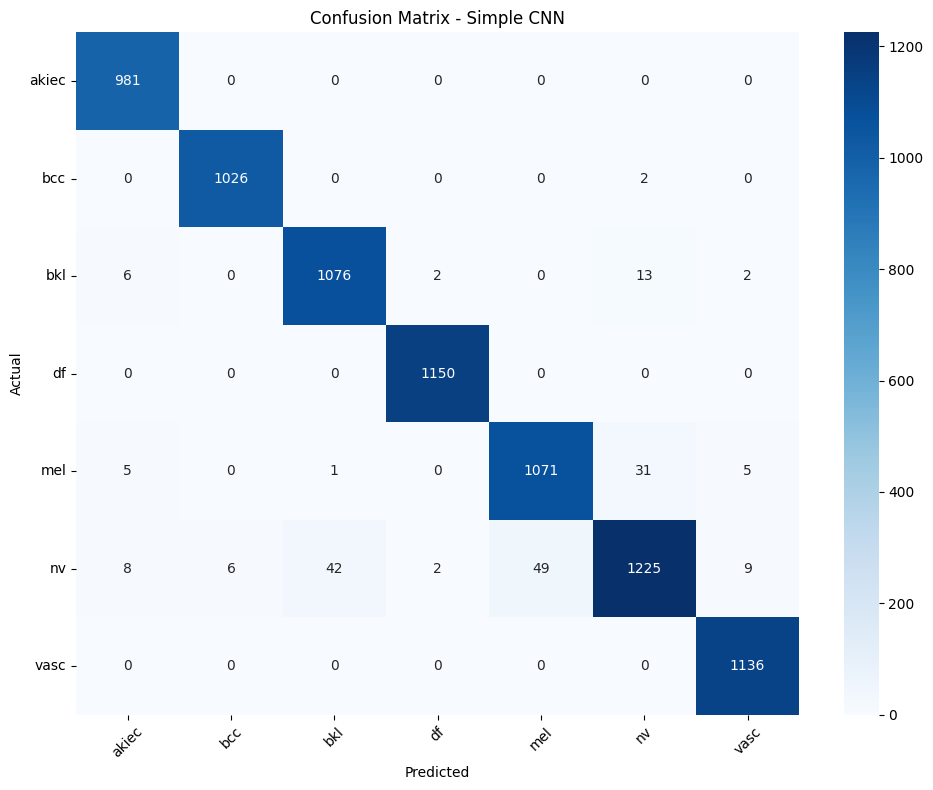

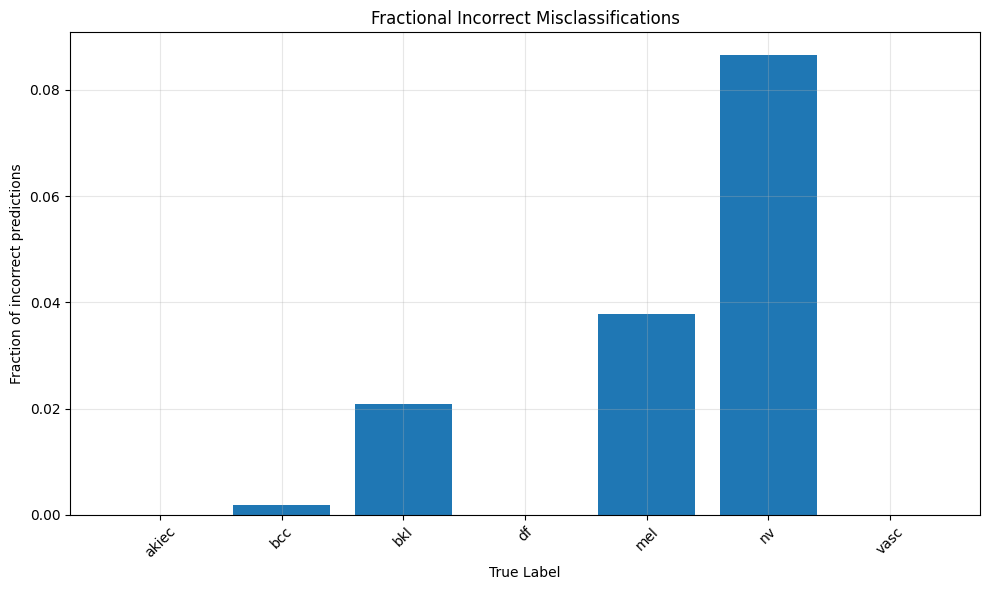


Classification Report:
              precision    recall  f1-score   support

       akiec       0.98      1.00      0.99       981
         bcc       0.99      1.00      1.00      1028
         bkl       0.96      0.98      0.97      1099
          df       1.00      1.00      1.00      1150
         mel       0.96      0.96      0.96      1113
          nv       0.96      0.91      0.94      1341
        vasc       0.99      1.00      0.99      1136

    accuracy                           0.98      7848
   macro avg       0.98      0.98      0.98      7848
weighted avg       0.98      0.98      0.98      7848



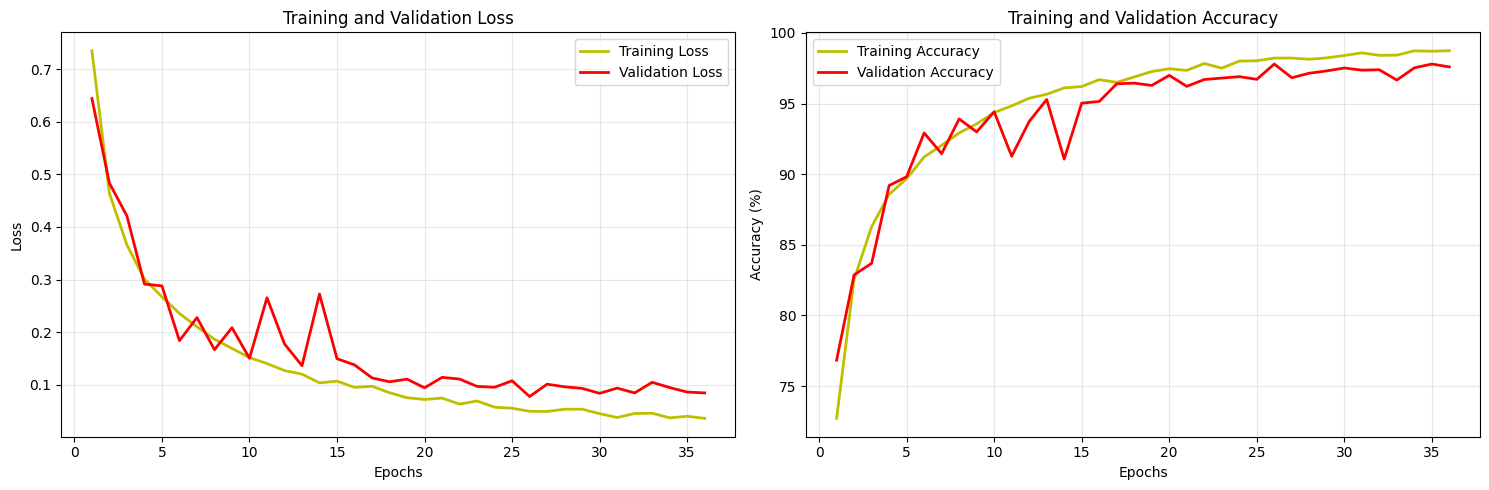

2025/08/22 18:55:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/22 18:55:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/22 18:55:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 36
✅ Best epoch: 26
✅ Final test accuracy: 97.67%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run ResNet_Size224_AugTrue_Batch64 at: http://localhost:5000/#/experiments/959049885417408975/runs/edbff2930316418c884c963a1ac540f5
🧪 View experiment at: http://localhost:5000/#/experiments/959049885417408975


In [29]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=50, patience=10, image_size=224, data_augmentation=True,
    notes="ResNet50-DA-ClassSpecificAug", 
    data_balancing="class-specific augmentation rates"
)

The high accuracy is likely due to **data leakage** - when we applied class-specific augmentation rates to the entire dataset before splitting, the same images (including duplicates) appeared across train, validation, and test sets.

**The Problem:** Augmenting first, then splitting means the model sees identical or near-identical images during training and testing, artificially inflating performance metrics.

**The Solution:** Split the data first into train/val/test, then apply class-specific balancing only to the training set. This ensures validation and test sets contain truly unseen images, giving more realistic and trustworthy performance metrics.

**Expected Result:** Test accuracy will likely drop to more realistic levels, but the evaluation will be clean and defensible.

## 🏋️‍♂️ Train ResNet50-DA-SplitFirst-ClassAug

- Split first: Data is split into train/val/test before any balancing
- Balance only training set: The balance_training_data() function only applies multiplication to the training data
- Validation and test remain original: Val and test sets keep the natural class distribution
- Add overlap check: Function to verify no images appear in multiple sets

In [30]:
# Load metadata
metadata = pd.read_csv(os.path.join(input_path, "HAM10000_metadata.csv"))

label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
print("Original dataset distribution:")
print(metadata['label'].value_counts())

Original dataset distribution:
label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [31]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(input_path, '*', '*.jpg'))}
metadata['path'] = metadata['image_id'].map(image_path.get)

In [32]:
# SPLIT FIRST - by unique images to avoid any overlap
train_df, test_df = train_test_split(
    metadata, 
    test_size=0.2, 
    random_state=42, 
    stratify=metadata['label']
)
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.25, 
    random_state=42, 
    stratify=train_df['label']
)

print(f"\nAfter splitting:")
print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")


After splitting:
Train: 6009 samples
Val: 2003 samples
Test: 2003 samples


In [33]:
# NOW BALANCE ONLY THE TRAINING SET
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]

def balance_training_data(train_df, data_aug_rate):
    """Balance only the training data by class"""
    balanced_dfs = []
    
    for class_idx, rate in enumerate(data_aug_rate):
        class_df = train_df[train_df['label'] == class_idx]
        if len(class_df) > 0 and rate > 0:
            # Multiply the class by the rate
            augmented_df = pd.concat([class_df] * rate, ignore_index=True)
            balanced_dfs.append(augmented_df)
        elif len(class_df) > 0:
            # Rate 0 means use original
            balanced_dfs.append(class_df)
    
    return pd.concat(balanced_dfs, ignore_index=True)

# Balance only training data
train_df_balanced = balance_training_data(train_df, data_aug_rate)

print(f"\nBalanced training set distribution:")
print(train_df_balanced['label'].value_counts().sort_index())
print(f"Balanced training set size: {len(train_df_balanced)}")

# Validation and test sets remain unbalanced (original distribution)
print(f"\nValidation set distribution:")
print(val_df['label'].value_counts().sort_index())
print(f"\nTest set distribution:")
print(test_df['label'].value_counts().sort_index())


Balanced training set distribution:
label
0    2955
1    3080
2    3295
3    3450
4    3340
5    4023
6    3400
Name: count, dtype: int64
Balanced training set size: 23543

Validation set distribution:
label
0      65
1     103
2     220
3      23
4     222
5    1341
6      29
Name: count, dtype: int64

Test set distribution:
label
0      65
1     103
2     220
3      23
4     223
5    1341
6      28
Name: count, dtype: int64


In [34]:
# Verify no image overlap between sets
def check_image_overlap(train_df, val_df, test_df):
    """Check if there are any overlapping images between train/val/test"""
    train_imgs = set(train_df['image_id'].unique())
    val_imgs = set(val_df['image_id'].unique())
    test_imgs = set(test_df['image_id'].unique())
    
    train_val_overlap = train_imgs.intersection(val_imgs)
    train_test_overlap = train_imgs.intersection(test_imgs)
    val_test_overlap = val_imgs.intersection(test_imgs)
    
    print(f"\nImage overlap check:")
    print(f"Train-Val overlap: {len(train_val_overlap)} images")
    print(f"Train-Test overlap: {len(train_test_overlap)} images")
    print(f"Val-Test overlap: {len(val_test_overlap)} images")
    
    if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
        print("✓ No image overlap between sets - clean split!")
    else:
        print("⚠ Warning: Image overlap detected!")

# Run the overlap check
check_image_overlap(train_df_balanced, val_df, test_df)


Image overlap check:
Train-Val overlap: 0 images
Train-Test overlap: 0 images
Val-Test overlap: 0 images
✓ No image overlap between sets - clean split!


In [35]:
# Set up transforms
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [36]:
# Create custom dataset class
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        # Pre-extract paths and labels for faster access
        self.image_paths = dataframe['path'].values
        self.labels = dataframe['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Fast numpy array access
        label = self.labels[idx]            # Fast numpy array access

        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets with transforms (using balanced training set)
train_dataset = SkinDataset(train_df_balanced, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

In [37]:
# Enable PyTorch optimizations
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,              # 2x larger (or 128 if GPU memory allows)
    shuffle=True,
    num_workers=8,              # 2x more workers
    pin_memory=True,            # Speeds up CPU->GPU transfer
    persistent_workers=True,    # Keeps workers alive between epochs
    prefetch_factor=4           # Prefetch multiple batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,             # Even larger for validation (no gradients)
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,             # Larger batch
    shuffle=False,
    num_workers=4,              # Keep moderate
    pin_memory=True             # No persistent_workers for one-time use
)


In [38]:
# Create ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/150: 100%|██████████| 368/368 [00:42<00:00,  8.68it/s, loss=0.6793, accuracy=74.70%]


Epoch 1: loss: 0.6793 - accuracy: 74.70% - val_loss: 0.7660 - val_accuracy: 71.39%
Validation loss improved. Best model updated.


Epoch 2/150: 100%|██████████| 368/368 [00:40<00:00,  9.19it/s, loss=0.4019, accuracy=84.87%]


Epoch 2: loss: 0.4019 - accuracy: 84.87% - val_loss: 0.5671 - val_accuracy: 81.13%
Validation loss improved. Best model updated.


Epoch 3/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.3067, accuracy=88.37%]


Epoch 3: loss: 0.3067 - accuracy: 88.37% - val_loss: 0.5384 - val_accuracy: 81.53%
Validation loss improved. Best model updated.


Epoch 4/150: 100%|██████████| 368/368 [00:40<00:00,  9.17it/s, loss=0.2460, accuracy=90.68%]


Epoch 4: loss: 0.2460 - accuracy: 90.68% - val_loss: 0.6329 - val_accuracy: 78.43%
No improvement. Patience: 1/20


Epoch 5/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.2060, accuracy=92.29%]


Epoch 5: loss: 0.2060 - accuracy: 92.29% - val_loss: 0.5699 - val_accuracy: 80.73%
No improvement. Patience: 2/20


Epoch 6/150: 100%|██████████| 368/368 [00:40<00:00,  9.17it/s, loss=0.1742, accuracy=93.66%]


Epoch 6: loss: 0.1742 - accuracy: 93.66% - val_loss: 0.7772 - val_accuracy: 74.29%
No improvement. Patience: 3/20


Epoch 7/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.1570, accuracy=94.32%]


Epoch 7: loss: 0.1570 - accuracy: 94.32% - val_loss: 0.6507 - val_accuracy: 81.28%
No improvement. Patience: 4/20


Epoch 8/150: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.1313, accuracy=95.30%]


Epoch 8: loss: 0.1313 - accuracy: 95.30% - val_loss: 0.6083 - val_accuracy: 81.23%
No improvement. Patience: 5/20


Epoch 9/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.1180, accuracy=95.66%]


Epoch 9: loss: 0.1180 - accuracy: 95.66% - val_loss: 0.6484 - val_accuracy: 83.62%
No improvement. Patience: 6/20


Epoch 10/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.1089, accuracy=96.05%]


Epoch 10: loss: 0.1089 - accuracy: 96.05% - val_loss: 0.5959 - val_accuracy: 83.18%
No improvement. Patience: 7/20


Epoch 11/150: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.0968, accuracy=96.42%]


Epoch 11: loss: 0.0968 - accuracy: 96.42% - val_loss: 0.7093 - val_accuracy: 82.38%
No improvement. Patience: 8/20


Epoch 12/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.1037, accuracy=96.33%]


Epoch 12: loss: 0.1037 - accuracy: 96.33% - val_loss: 0.6921 - val_accuracy: 80.48%
No improvement. Patience: 9/20


Epoch 13/150: 100%|██████████| 368/368 [00:40<00:00,  9.17it/s, loss=0.0853, accuracy=96.88%]


Epoch 13: loss: 0.0853 - accuracy: 96.88% - val_loss: 0.6413 - val_accuracy: 84.52%
No improvement. Patience: 10/20


Epoch 14/150: 100%|██████████| 368/368 [00:40<00:00,  9.13it/s, loss=0.0748, accuracy=97.31%]


Epoch 14: loss: 0.0748 - accuracy: 97.31% - val_loss: 0.7188 - val_accuracy: 81.58%
No improvement. Patience: 11/20


Epoch 15/150: 100%|██████████| 368/368 [00:40<00:00,  9.19it/s, loss=0.0799, accuracy=97.18%]


Epoch 15: loss: 0.0799 - accuracy: 97.18% - val_loss: 0.6195 - val_accuracy: 83.82%
No improvement. Patience: 12/20


Epoch 16/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.0679, accuracy=97.73%]


Epoch 16: loss: 0.0679 - accuracy: 97.73% - val_loss: 0.7455 - val_accuracy: 80.63%
No improvement. Patience: 13/20


Epoch 17/150: 100%|██████████| 368/368 [00:40<00:00,  9.19it/s, loss=0.0550, accuracy=98.11%]


Epoch 17: loss: 0.0550 - accuracy: 98.11% - val_loss: 0.7586 - val_accuracy: 82.58%
No improvement. Patience: 14/20


Epoch 18/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.0665, accuracy=97.75%]


Epoch 18: loss: 0.0665 - accuracy: 97.75% - val_loss: 0.6064 - val_accuracy: 83.23%
No improvement. Patience: 15/20


Epoch 19/150: 100%|██████████| 368/368 [00:40<00:00,  9.18it/s, loss=0.0546, accuracy=98.03%]


Epoch 19: loss: 0.0546 - accuracy: 98.03% - val_loss: 0.6495 - val_accuracy: 84.22%
No improvement. Patience: 16/20


Epoch 20/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.0563, accuracy=98.08%]


Epoch 20: loss: 0.0563 - accuracy: 98.08% - val_loss: 0.8686 - val_accuracy: 78.98%
No improvement. Patience: 17/20


Epoch 21/150: 100%|██████████| 368/368 [00:40<00:00,  9.18it/s, loss=0.0561, accuracy=98.04%]


Epoch 21: loss: 0.0561 - accuracy: 98.04% - val_loss: 0.6953 - val_accuracy: 85.17%
No improvement. Patience: 18/20


Epoch 22/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.0487, accuracy=98.34%]


Epoch 22: loss: 0.0487 - accuracy: 98.34% - val_loss: 0.7679 - val_accuracy: 83.08%
No improvement. Patience: 19/20


Epoch 23/150: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.0442, accuracy=98.46%]


Epoch 23: loss: 0.0442 - accuracy: 98.46% - val_loss: 0.6772 - val_accuracy: 84.72%
No improvement. Patience: 20/20
Early stopping triggered after 23 epochs
Best model from epoch 3 loaded

Test Results:
Test Loss: 0.6739
Test Accuracy: 84.12%


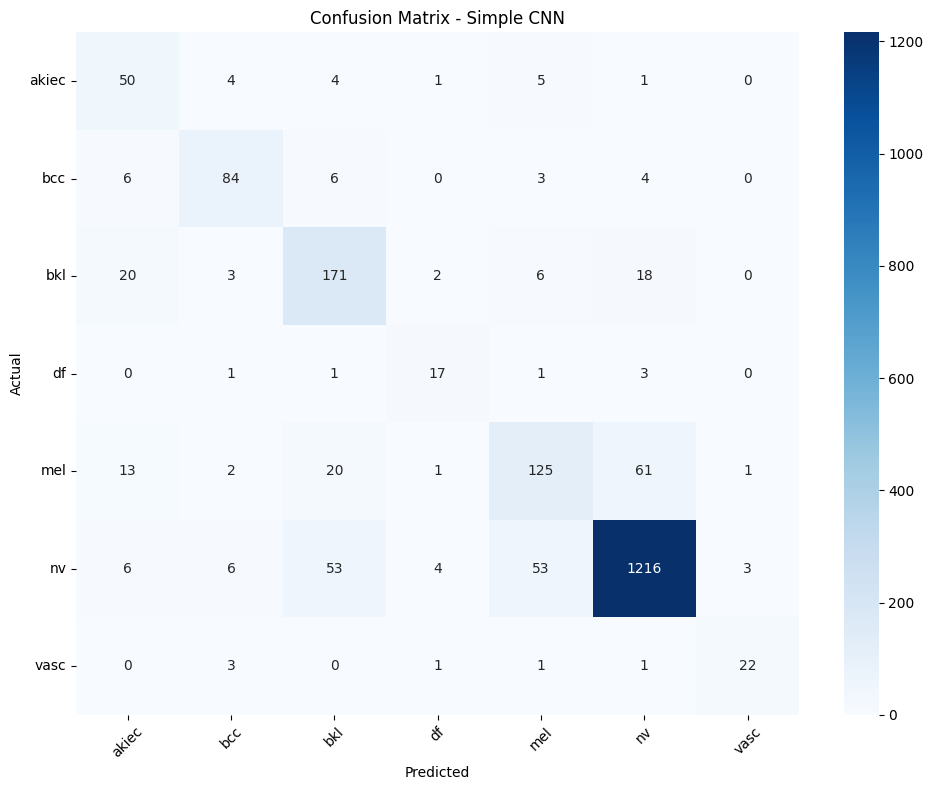

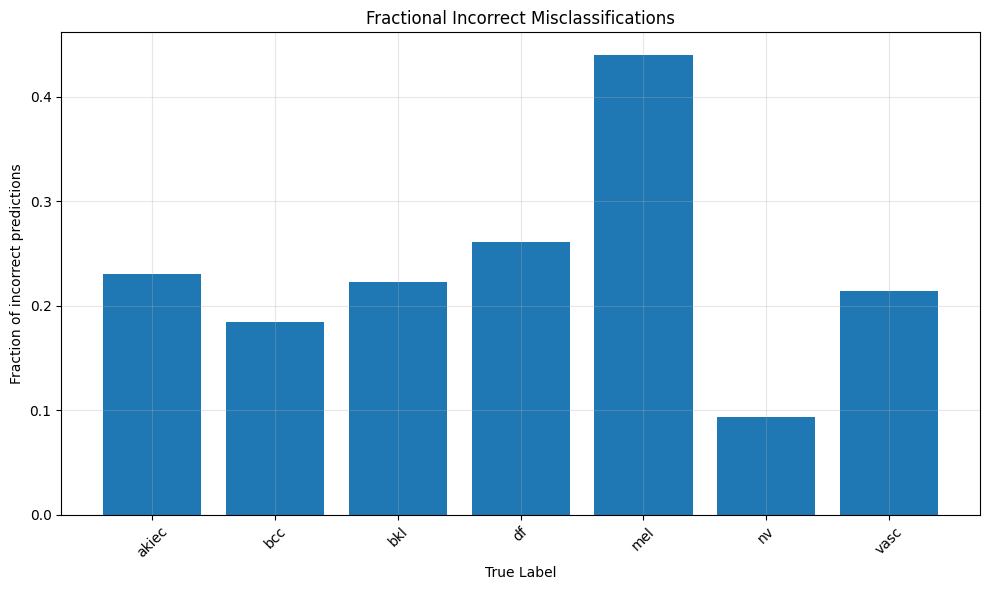


Classification Report:
              precision    recall  f1-score   support

       akiec       0.53      0.77      0.62        65
         bcc       0.82      0.82      0.82       103
         bkl       0.67      0.78      0.72       220
          df       0.65      0.74      0.69        23
         mel       0.64      0.56      0.60       223
          nv       0.93      0.91      0.92      1341
        vasc       0.85      0.79      0.81        28

    accuracy                           0.84      2003
   macro avg       0.73      0.76      0.74      2003
weighted avg       0.85      0.84      0.84      2003



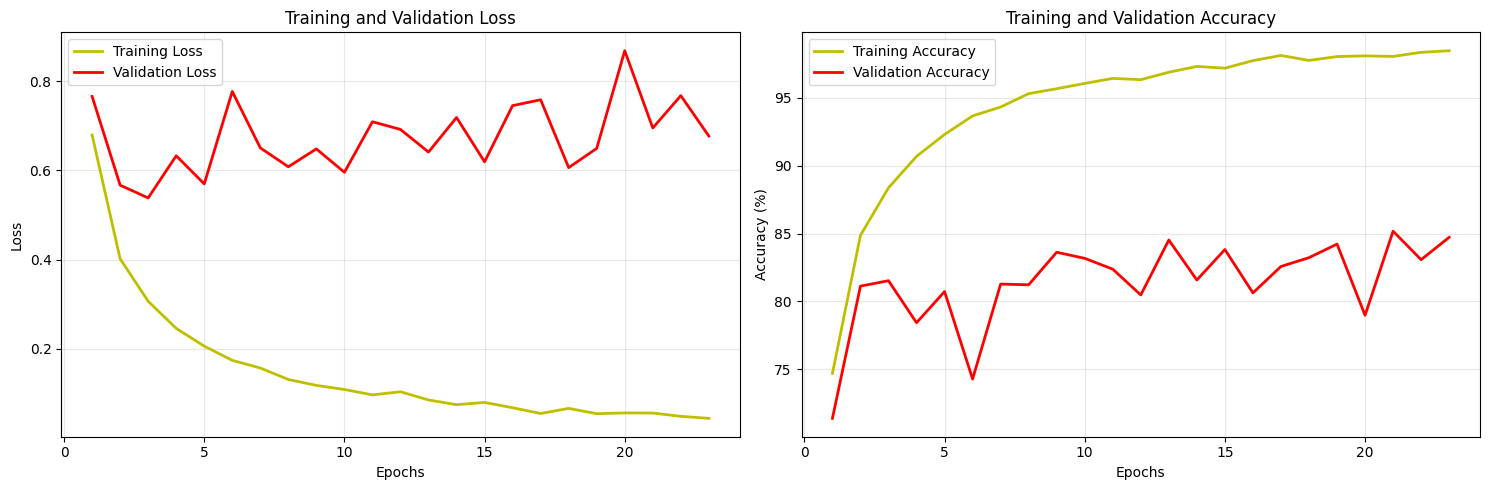

2025/08/22 19:14:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/22 19:14:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/22 19:14:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 23
✅ Best epoch: 3
✅ Final test accuracy: 84.12%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run ResNet_Size224_AugTrue_Batch64 at: http://localhost:5000/#/experiments/959049885417408975/runs/fe71ec75db8d47448a6ba0d422e90403
🧪 View experiment at: http://localhost:5000/#/experiments/959049885417408975


In [39]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=150, patience=20, image_size=224, data_augmentation=True,
    notes="ResNet50-DA-SplitFirst-ClassSpecificAug",
    data_balancing="class-specific augmentation rates"
)

Now we have much more realistic results with 84.87% test accuracy! This represents the model's true performance on unseen data without data leakage.

## 🏋️‍♂️ Train ResNet50-DA-SplitFirst-ClassAug-Reg-Scheduler
**2 types of regularization**:
1. **Dropout (0.1)** - Randomly sets 20% of neurons to zero during training to prevent overfitting
2. **L2 regularization (weight_decay=1e-5)** - Adds penalty to large weights in the loss function to encourage simpler models

The ReduceLROnPlateau scheduler helps combat overfitting by reducing the learning rate when validation loss stops improving.

In [40]:
# Create ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.1), # Dropout
    nn.Linear(model.fc.in_features, 7)
)
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Epoch 1/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.6950, accuracy=74.17%]


Epoch 1: loss: 0.6950 - accuracy: 74.17% - val_loss: 0.8554 - val_accuracy: 66.65%
Validation loss improved. Best model updated.


Epoch 2/150: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.4116, accuracy=84.31%]


Epoch 2: loss: 0.4116 - accuracy: 84.31% - val_loss: 0.7667 - val_accuracy: 70.34%
Validation loss improved. Best model updated.


Epoch 3/150: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.3258, accuracy=87.81%]


Epoch 3: loss: 0.3258 - accuracy: 87.81% - val_loss: 0.5376 - val_accuracy: 79.93%
Validation loss improved. Best model updated.


Epoch 4/150: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.2621, accuracy=90.17%]


Epoch 4: loss: 0.2621 - accuracy: 90.17% - val_loss: 0.6721 - val_accuracy: 76.34%
No improvement. Patience: 1/20


Epoch 5/150: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.2178, accuracy=91.79%]


Epoch 5: loss: 0.2178 - accuracy: 91.79% - val_loss: 0.6224 - val_accuracy: 79.28%
No improvement. Patience: 2/20


Epoch 6/150: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.2016, accuracy=92.45%]


Epoch 6: loss: 0.2016 - accuracy: 92.45% - val_loss: 0.6215 - val_accuracy: 81.08%
No improvement. Patience: 3/20


Epoch 7/150: 100%|██████████| 368/368 [00:40<00:00,  9.10it/s, loss=0.1787, accuracy=93.31%]


Epoch 7: loss: 0.1787 - accuracy: 93.31% - val_loss: 0.7025 - val_accuracy: 77.88%
No improvement. Patience: 4/20


Epoch 8/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.1531, accuracy=94.47%]


Epoch 8: loss: 0.1531 - accuracy: 94.47% - val_loss: 0.6756 - val_accuracy: 77.58%
No improvement. Patience: 5/20


Epoch 9/150: 100%|██████████| 368/368 [00:40<00:00,  9.10it/s, loss=0.1449, accuracy=94.84%]


Epoch 9: loss: 0.1449 - accuracy: 94.84% - val_loss: 0.5899 - val_accuracy: 81.53%
No improvement. Patience: 6/20


Epoch 10/150: 100%|██████████| 368/368 [00:40<00:00,  9.12it/s, loss=0.0722, accuracy=97.46%]


Epoch 10: loss: 0.0722 - accuracy: 97.46% - val_loss: 0.5463 - val_accuracy: 85.27%
No improvement. Patience: 7/20


Epoch 11/150: 100%|██████████| 368/368 [00:40<00:00,  9.11it/s, loss=0.0560, accuracy=98.01%]


Epoch 11: loss: 0.0560 - accuracy: 98.01% - val_loss: 0.5971 - val_accuracy: 85.27%
No improvement. Patience: 8/20


Epoch 12/150: 100%|██████████| 368/368 [00:40<00:00,  9.13it/s, loss=0.0562, accuracy=97.98%]


Epoch 12: loss: 0.0562 - accuracy: 97.98% - val_loss: 0.5704 - val_accuracy: 85.42%
No improvement. Patience: 9/20


Epoch 13/150: 100%|██████████| 368/368 [00:40<00:00,  9.09it/s, loss=0.0475, accuracy=98.33%]


Epoch 13: loss: 0.0475 - accuracy: 98.33% - val_loss: 0.6361 - val_accuracy: 85.52%
No improvement. Patience: 10/20


Epoch 14/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.0562, accuracy=98.05%]


Epoch 14: loss: 0.0562 - accuracy: 98.05% - val_loss: 0.5841 - val_accuracy: 84.72%
No improvement. Patience: 11/20


Epoch 15/150: 100%|██████████| 368/368 [00:40<00:00,  9.10it/s, loss=0.0488, accuracy=98.31%]


Epoch 15: loss: 0.0488 - accuracy: 98.31% - val_loss: 0.6355 - val_accuracy: 85.42%
No improvement. Patience: 12/20


Epoch 16/150: 100%|██████████| 368/368 [00:40<00:00,  9.16it/s, loss=0.0234, accuracy=99.27%]


Epoch 16: loss: 0.0234 - accuracy: 99.27% - val_loss: 0.6595 - val_accuracy: 85.67%
No improvement. Patience: 13/20


Epoch 17/150: 100%|██████████| 368/368 [00:40<00:00,  9.10it/s, loss=0.0156, accuracy=99.49%]


Epoch 17: loss: 0.0156 - accuracy: 99.49% - val_loss: 0.6481 - val_accuracy: 86.27%
No improvement. Patience: 14/20


Epoch 18/150: 100%|██████████| 368/368 [00:40<00:00,  9.15it/s, loss=0.0141, accuracy=99.55%]


Epoch 18: loss: 0.0141 - accuracy: 99.55% - val_loss: 0.7063 - val_accuracy: 86.42%
No improvement. Patience: 15/20


Epoch 19/150: 100%|██████████| 368/368 [00:40<00:00,  9.12it/s, loss=0.0182, accuracy=99.41%]


Epoch 19: loss: 0.0182 - accuracy: 99.41% - val_loss: 0.7188 - val_accuracy: 86.27%
No improvement. Patience: 16/20


Epoch 20/150: 100%|██████████| 368/368 [00:40<00:00,  9.14it/s, loss=0.0151, accuracy=99.49%]


Epoch 20: loss: 0.0151 - accuracy: 99.49% - val_loss: 0.6782 - val_accuracy: 86.82%
No improvement. Patience: 17/20


Epoch 21/150: 100%|██████████| 368/368 [00:40<00:00,  9.12it/s, loss=0.0190, accuracy=99.36%]


Epoch 21: loss: 0.0190 - accuracy: 99.36% - val_loss: 0.6457 - val_accuracy: 86.82%
No improvement. Patience: 18/20


Epoch 22/150: 100%|██████████| 368/368 [00:40<00:00,  9.10it/s, loss=0.0077, accuracy=99.77%]


Epoch 22: loss: 0.0077 - accuracy: 99.77% - val_loss: 0.7257 - val_accuracy: 86.87%
No improvement. Patience: 19/20


Epoch 23/150: 100%|██████████| 368/368 [00:40<00:00,  9.03it/s, loss=0.0061, accuracy=99.82%]


Epoch 23: loss: 0.0061 - accuracy: 99.82% - val_loss: 0.6962 - val_accuracy: 86.97%
No improvement. Patience: 20/20
Early stopping triggered after 23 epochs
Best model from epoch 3 loaded

Test Results:
Test Loss: 0.6816
Test Accuracy: 87.72%


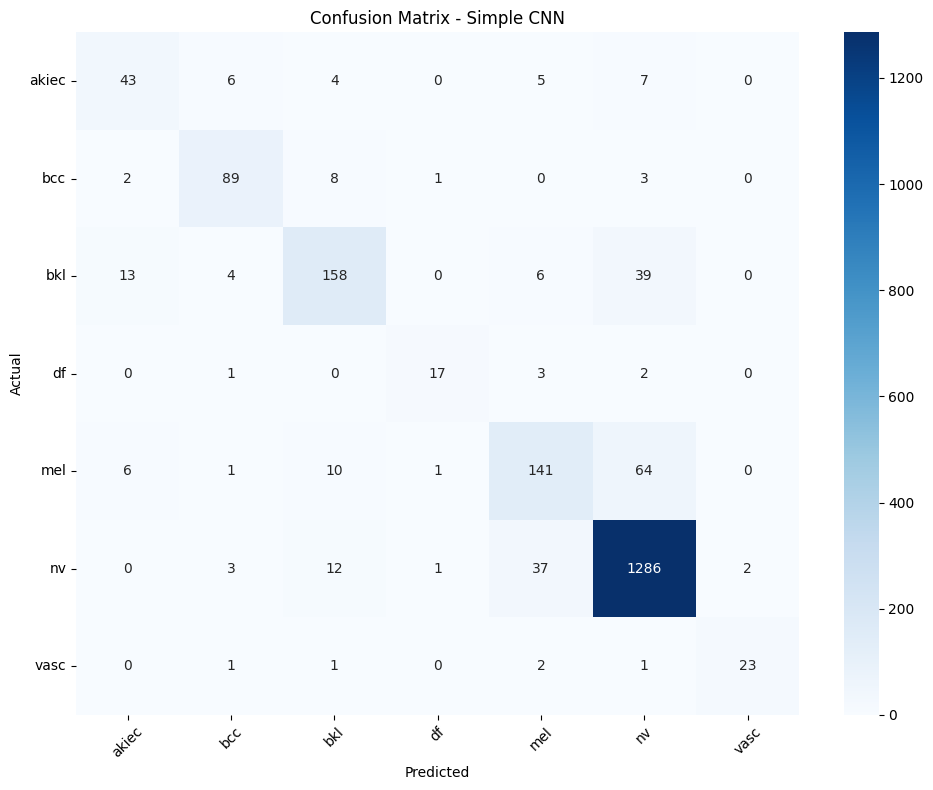

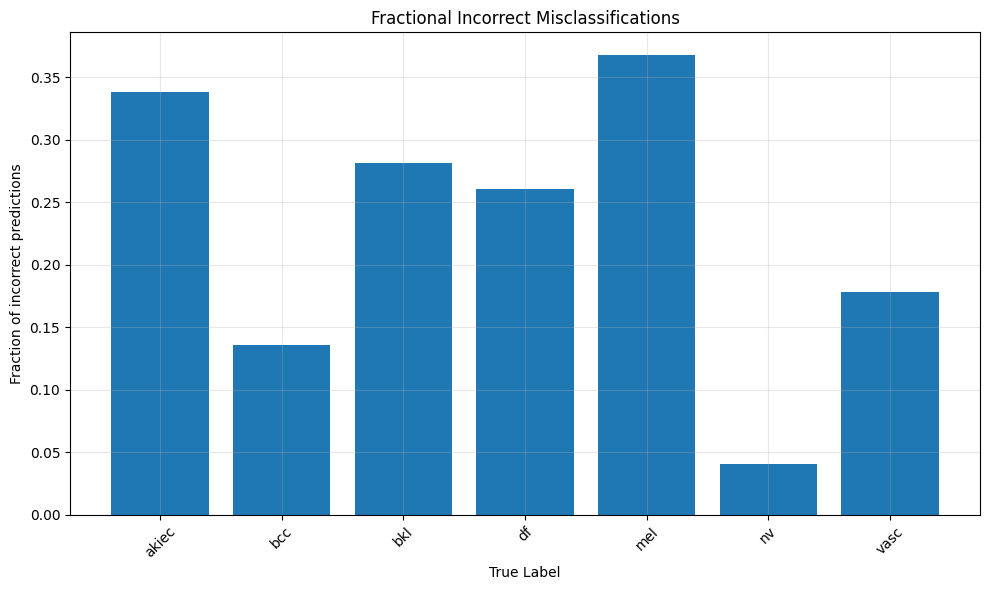


Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.66      0.67        65
         bcc       0.85      0.86      0.86       103
         bkl       0.82      0.72      0.77       220
          df       0.85      0.74      0.79        23
         mel       0.73      0.63      0.68       223
          nv       0.92      0.96      0.94      1341
        vasc       0.92      0.82      0.87        28

    accuracy                           0.88      2003
   macro avg       0.82      0.77      0.79      2003
weighted avg       0.87      0.88      0.87      2003



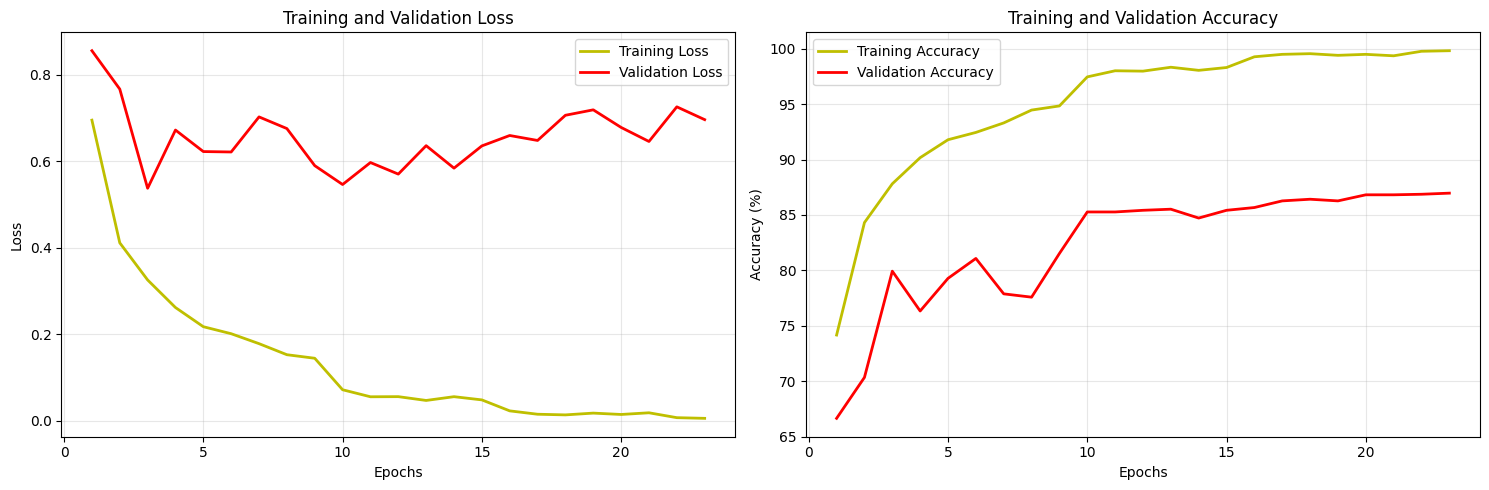

2025/08/22 19:31:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/22 19:31:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/22 19:31:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 23
✅ Best epoch: 3
✅ Final test accuracy: 87.72%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run ResNet_Size224_AugTrue_Batch64 at: http://localhost:5000/#/experiments/959049885417408975/runs/b74fee0638454d8c8090d69e75c7c52b
🧪 View experiment at: http://localhost:5000/#/experiments/959049885417408975


In [41]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    data_balancing="class-specific augmentation rates",
    scheduler=scheduler, 
    num_epochs=150, patience=20, image_size=224, data_augmentation=True,
    notes="ResNet50-DA-SplitFirst-ClassAug-Scheduler-Drop0.1-L2"
)

Here We Are!

## ⚡ Run Inference

1. Load the model from MLflow
2. load the ISIC 2019 data from https://www.kaggle.com/datasets/agsam23/isic-2019-challenge/data

In [43]:
# Load the model
model_path = "/workspace/mlartifacts/959049885417408975/models/m-124cd932cf1a4b718fa6e2ddff457bfb/artifacts"
trained_model = mlflow.pytorch.load_model(f"file://{model_path}")

print("Model loaded:", trained_model is not None)
print("Model type:", type(trained_model))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Quick inference test
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = trained_model(dummy_input)
    print("Output shape:", output.shape)  # Should be [1, 7]
    print("Predictions:", torch.softmax(output, dim=1))

Model loaded: True
Model type: <class 'torchvision.models.resnet.ResNet'>
Output shape: torch.Size([1, 7])
Predictions: tensor([[1.4783e-14, 3.3847e-14, 1.0000e+00, 3.8012e-08, 1.5876e-06, 7.7940e-08,
         4.9874e-17]], device='cuda:0')


In [44]:
# Paths
input_path_isic2019 = "datasets/skin_cancer/ISIC_2019/"

# Load ground truth CSV
isic_df = pd.read_csv(os.path.join(input_path_isic2019, "ISIC_2019_Training_GroundTruth.csv"))
isic_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
print(f"Original dataset size: {len(isic_df)}")

Original dataset size: 25331


In [46]:
# Keep only 7 classes (drop SCC, UNK) since the model was trained on these classes only.
your_classes = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
filtered_df = isic_df[isic_df[your_classes].sum(axis=1) == 1].copy()
print(f"After filtering: {len(filtered_df)}")

After filtering: 24703


In [47]:
# Map ISIC labels to your model labels
label_mapping = {'MEL': 'mel', 'NV': 'nv', 'BCC': 'bcc', 'AK': 'akiec',
               'BKL': 'bkl', 'DF': 'df', 'VASC': 'vasc'}

# Convert one-hot to single label
def get_label(row):
   for col in your_classes:
       if row[col] == 1:
           return label_mapping[col]

filtered_df['diagnosis'] = filtered_df.apply(get_label, axis=1)

# Correct paths with nested folders
train_images_path = os.path.join(input_path_isic2019, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input")
test_images_path = os.path.join(input_path_isic2019, "ISIC_2019_Test_Input", "ISIC_2019_Test_Input")

# Create image path mapping with .jpg extension
image_path_mapping = {}

# Add training images
for img_file in os.listdir(train_images_path):
    if img_file.endswith('.jpg'):
        img_id = os.path.splitext(img_file)[0]
        image_path_mapping[img_id] = os.path.join(train_images_path, img_file)

# Add test images
for img_file in os.listdir(test_images_path):
    if img_file.endswith('.jpg'):
        img_id = os.path.splitext(img_file)[0]
        image_path_mapping[img_id] = os.path.join(test_images_path, img_file)

# Add image paths to dataframe
filtered_df['image_path'] = filtered_df['image'].map(image_path_mapping)

# Remove rows where image path not found
filtered_df = filtered_df.dropna(subset=['image_path'])

print(f"Final dataset size: {len(filtered_df)}")
print("Class distribution:")
print(filtered_df['diagnosis'].value_counts())

Final dataset size: 24703
Class distribution:
diagnosis
nv       12875
mel       4522
bcc       3323
bkl       2624
akiec      867
vasc       253
df         239
Name: count, dtype: int64


In [48]:
# Create inference dataset
class ISICInferenceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = dataframe['image_path'].values
        self.labels = dataframe['diagnosis'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Same preprocessing as our training
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset and loader
isic_dataset = ISICInferenceDataset(filtered_df, transform=inference_transform)
isic_loader = DataLoader(isic_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Ready to test on {len(isic_dataset)} ISIC 2019 images!")

Ready to test on 24703 ISIC 2019 images!


🚀 Starting ISIC 2019 External Validation evaluation...
   Processed 64 samples...
   Processed 3,264 samples...
   Processed 6,464 samples...
   Processed 9,664 samples...
   Processed 12,864 samples...
   Processed 16,064 samples...
   Processed 19,264 samples...
   Processed 22,464 samples...
✅ Completed evaluation on 24,703 samples

ISIC 2019 External Validation - Results Summary
🎯 Overall Accuracy: 0.7037 (70.37%)
📊 Average Confidence: 0.948
📈 Total Samples: 24,703

Performance Breakdown:
  ✅ High Confidence Correct: 16,507 (66.8%)
  ⚠️  Low Confidence Correct:  877 (3.6%)
  ❌ Incorrect Predictions:   7,319 (29.6%)


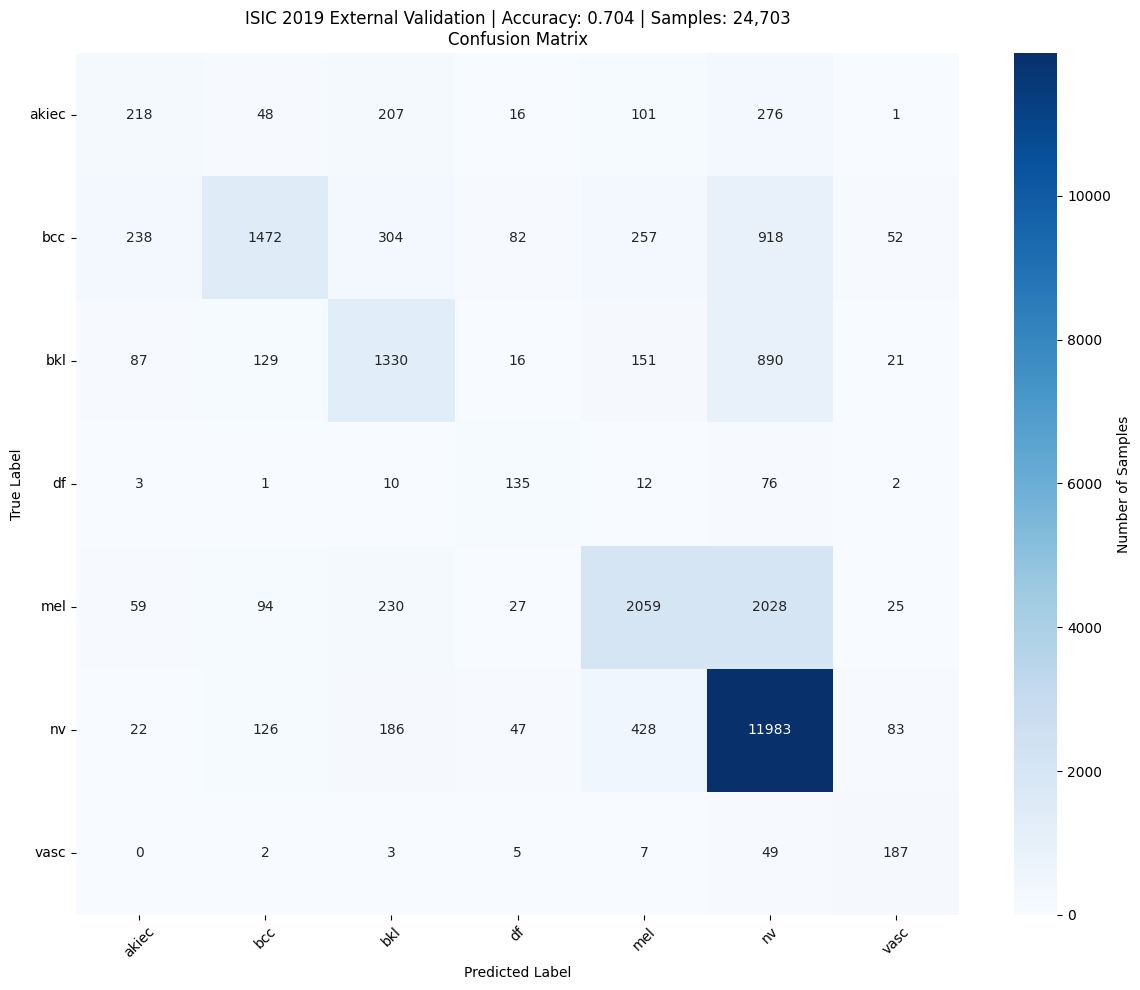

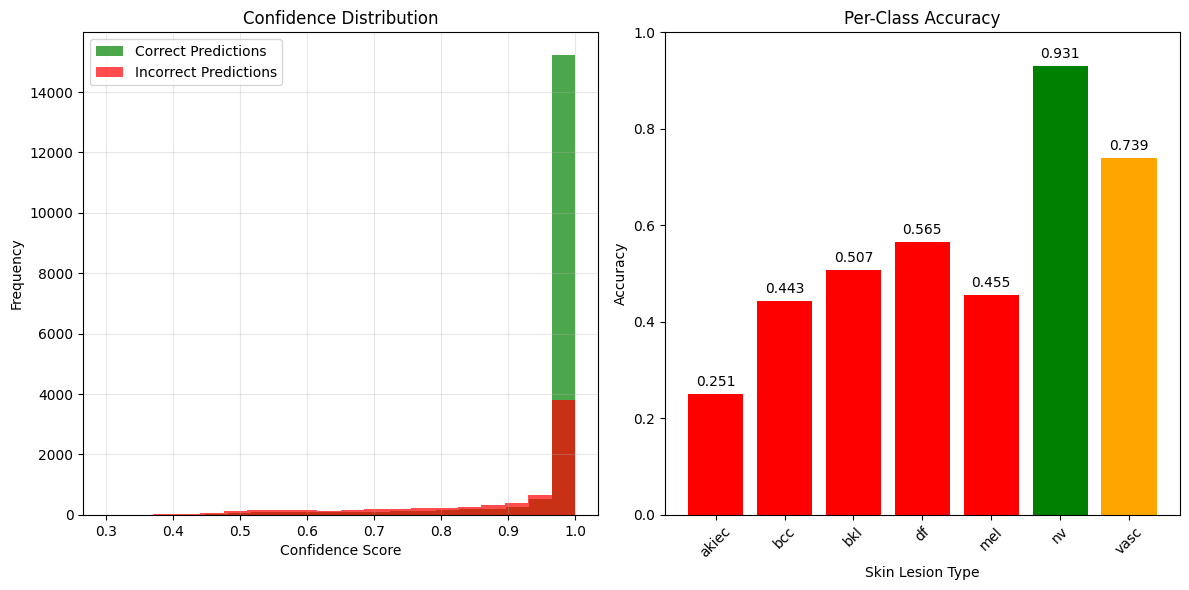

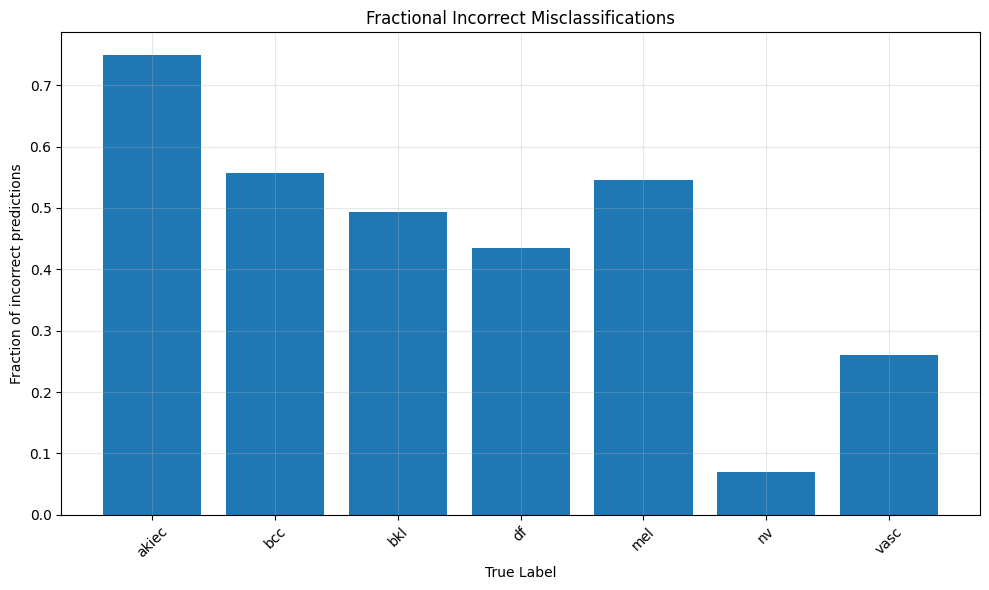


Detailed Classification Report:
              precision    recall  f1-score   support

       akiec       0.35      0.25      0.29       867
         bcc       0.79      0.44      0.57      3323
         bkl       0.59      0.51      0.54      2624
          df       0.41      0.56      0.48       239
         mel       0.68      0.46      0.55      4522
          nv       0.74      0.93      0.82     12875
        vasc       0.50      0.74      0.60       253

    accuracy                           0.70     24703
   macro avg       0.58      0.56      0.55     24703
weighted avg       0.70      0.70      0.68     24703



In [49]:
sys.path.append('helpers')
import tester
import importlib
importlib.reload(tester)
from tester import Tester

# Move model to device
trained_model = trained_model.to(device)
trained_model.eval()

# Run complete evaluation with Tester
Tester.test(
    model=trained_model,
    dataloader=isic_loader,
    label_names=label_names,
    device=device,
    title="ISIC 2019 External Validation"
)

**70% on completely unseen external data is actually good!**

- HAM10000 test (clean split): 87.72% - realistic performance on same dataset
- ISIC2019 (external dataset): 70% - expected drop on completely different data

87.72% → 70% is exactly what we want to see - it shows our model learned generalizable features, not just memorized training examples.

## 💾 Save the model to the local machine 

In [50]:
# Current model loading code
model_path = "/workspace/mlartifacts/959049885417408975/models/m-124cd932cf1a4b718fa6e2ddff457bfb/artifacts"
trained_model = mlflow.pytorch.load_model(f"file://{model_path}")
print("Model loaded:", trained_model is not None)
print("Model type:", type(trained_model))

# Create the destination directory if it doesn't exist
os.makedirs("/workspace/models/skin", exist_ok=True)

# Save the model to the new location
mlflow.pytorch.save_model(trained_model, "/workspace/models/skin")
print("Model saved successfully to /workspace/models/skin")

Model loaded: True
Model type: <class 'torchvision.models.resnet.ResNet'>


2025/08/22 19:42:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Model saved successfully to /workspace/models/skin
